In [1]:
import io
import boto3
import pandas as pd

def read_datasets():
    # Read three datasets stored in the Amazon S3 bucket
   # bucket = "faostat-ml"
    file_name = "Emissions_Totals_E_All_Data_(Normalized).csv"
    #s3_client = boto3.client("s3")
    #obj = s3_client.get_object(Bucket=bucket, Key=file_name)
    df_emission = pd.read_csv("Emissions_Totals_E_All_Data_(Normalized).csv",encoding='latin-1')
    df_emission.drop(df_emission.columns[df_emission.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

    #fix the feature names
    df_emission = df_emission.rename(columns={'Item': 'EmissionItem','Value': 'EmissionValue','Element': 'EmissionElement','Unit': 'EmissionUnit'})
    print(df_emission.head(5))

    file_name = "Production_Crops_Livestock_E_All_Data_(Normalized).csv"
    #obj = s3_client.get_object(Bucket=bucket, Key=file_name)
    df_prod = pd.read_csv("Production_Crops_Livestock_E_All_Data_(Normalized).csv",encoding='latin-1')
    df_prod.drop(df_prod.columns[df_prod.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    df_prod.drop('Unit', axis=1, inplace=True)
    print(df_prod.head(5))


    file_name = "Forestry_E_All_Data_(Normalized).csv"
    #obj = s3_client.get_object(Bucket=bucket, Key=file_name)
    df_forest = pd.read_csv("Forestry_E_All_Data_(Normalized).csv",encoding='latin-1')
    df_forest.drop(df_forest.columns[df_forest.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    print(df_forest.head(5))
    return df_emission, df_prod, df_forest

In [2]:
def pre_processing():
    remove_rows_df = pre_process_df.copy()
    
    # Removes area, source and emission unit that place no significant role
    remove_rows_df.drop('Area', axis=1, inplace=True)
    remove_rows_df.drop('Source', axis=1, inplace=True)
    remove_rows_df.drop('EmissionUnit', axis=1, inplace=True)
    
    # Remove redudant instance
    remove_rows_df = remove_rows_df[remove_rows_df.Element != "Area harvested"]
    remove_rows_df = remove_rows_df[remove_rows_df.Element != "Production"]
    remove_rows_df = remove_rows_df[remove_rows_df.Element != "Producing Animals/Slaughtered"]
    remove_rows_df = remove_rows_df[remove_rows_df.EmissionElement != "Indirect emissions (N2O)"]
    remove_rows_df = remove_rows_df[remove_rows_df.EmissionElement != "Direct emissions (N2O)"]
    remove_rows_df.index = remove_rows_df.Year
    remove_rows_df.drop('Year', axis=1, inplace=True)

    #identify partial string to look for
    discard = ['from']
    remove_rows_df = remove_rows_df[~remove_rows_df.EmissionElement.str.contains('|'.join(discard))]

    # Combine two features
    remove_rows_df["Emission"] = remove_rows_df["EmissionItem"] + str("_") + remove_rows_df["EmissionElement"]
    remove_rows_df.drop('EmissionItem', axis=1, inplace=True)
    remove_rows_df.drop('EmissionElement', axis=1, inplace=True)

    # Remove redudant instance
    remove_rows_df = remove_rows_df[remove_rows_df.Element != 'Import Value']
    remove_rows_df = remove_rows_df[remove_rows_df.Element != 'Export Value']
    
    emission_list = list(pre_process_df.EmissionItem.unique())

    # Create pivot table for production items + forestry products based on year and item
    df_item = remove_rows_df.pivot_table(index=['Year'], 
                columns=['Item'], values='Value')
    
    # Remove columns that have atleast one NaN value since it would affect the forecast
    sum = df_item.isnull().sum(axis = 0)
    for items in sum.iteritems():
        if(items[1]>0):
            df_item.drop(items[0], axis=1, inplace=True)
    nan_cols = [i for i in df_item.columns if df_item[i].isnull().any()]

    # Create pivot table for emissions
    df_emi = remove_rows_df.pivot_table(index=['Year'], 
                columns=['Emission'], values='EmissionValue')
    # Remove columns that have atleast one NaN value since it would affect the forecast
    sum = df_emi.isnull().sum(axis = 0)
    for items in sum.iteritems():
        if(items[1]>0):
            df_emi.drop(items[0], axis=1, inplace=True)
    nan_cols = [i for i in df_emi.columns if df_emi[i].isnull().any()]
    
    display(df_item.head(5))
    display(df_emi.head(5))
    return df_item, df_emi, emission_list

In [3]:
# Perform granger causation test - to check the influence of one variable over another

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    import numpy as np
    from statsmodels.tsa.stattools import grangercausalitytests
    maxlag=12
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [4]:
# Perform ADF test to check if each series is stationary or not

def adfuller_test(series, signif=0.05, name='', verbose=False):
    i = 0
    from statsmodels.tsa.api import VECM
    import semopy
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tools.eval_measures import rmse, aic
    non_stationary = []
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')
    
    for key,val in r[4].items():
        i = i + 1
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [5]:
# Revert back the differencing to get the forecast to original scale

def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [6]:
# Perform stationary test and differencing


""" Note: Comment out the 'for loop' when adf fuller test results need to be displayed"""

def stationary(df):
    nobs = 9
    df_train, df_test = df[0:-nobs], df[-nobs:]
    
    # ADF Test on each column
    #for name, column in df_train.iteritems():
        #adfuller_test(column, name=column.name)
        #print('\n')
        
    # 1st difference
    df_differenced = df_train.diff().dropna()
    #for name, column in df_differenced.iteritems():
        #adfuller_test(column, name=column.name)
        #print('\n')
        
    # Second Differencing
    df_differenced = df_differenced.diff().dropna()   
    #for name, column in df_differenced.iteritems():
        #adfuller_test(column, name=column.name)
        #print('\n')
        
    return df_differenced, df_train, df_test

In [7]:
# The function that performs forecasting

mae =[]
mse = []
sqr = []
    
def forecasting(df_item, df_emi, emission_list):
    import warnings
    import pandas as pd
    from numpy import sqrt 
    import plotly.graph_objs as go
    from statsmodels.tsa.api import VECM
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    warnings.simplefilter(action='ignore', category=FutureWarning)
    col = df_item.columns
    pandas_df = pd.DataFrame()
    nobs = 9

    # iterate through every item - production and forestry product - for the country/area specified
    for i in col:
        selected_columns = df_item[i]

        new_df = selected_columns.copy()
        new_merged_df = pd.merge(new_df, df_emi, on=['Year'])

        for j in emission_list:
            emission = new_merged_df.filter(regex=j)
            col = list(emission.columns) 
            new_merged_df[j] = new_merged_df[col].sum(axis=1)

        pandas_df = new_merged_df[new_merged_df.columns.intersection(emission_list)]
        pandas_df[str(new_merged_df.columns[0])] = new_merged_df[str(new_merged_df.columns[0])]
        pandas_df = pandas_df.loc[:, (pandas_df != 0).any(axis=0)]
         
        """ Note: comment out if granger test needs to be performed"""
        #print("Granger's causality test:")
        #display(grangers_causation_matrix(pandas_df, variables = pandas_df.columns))        
        
        historical_split1 = pandas_df.iloc[:50,:]
        historical_split2 = pandas_df.iloc[50:,:]
    
        df_differenced,df_train,_ = stationary(historical_split1)
       # model = VECM(df_differenced, order=(0,1,0)).fit()
        model = VECM(df_differenced)
        model_fitted = model.fit()

        # Get the lag order
        lag_order = model_fitted.k_ar

        # Input data for forecasting
        forecast_input = df_differenced.values[-lag_order:]
        fc = model_fitted.predict(steps=nobs)
        df_forecast = pd.DataFrame(fc, index=historical_split1.index[-nobs:], columns=historical_split1.columns + '_2d')

        df_results = invert_transformation(df_train, df_forecast, second_diff=True)
        d = historical_split1.tail(nobs)
        d.reset_index(inplace = True)


        range_year = pd.date_range(start = str(d.Year.iloc[-1]), periods = (len(d)+1), freq = 'A')
        range_year = range_year.year
        year = pd.DataFrame({'Year': range_year})
        d = d.append(year)
        year_forecast = d['Year'].iat[-1]

        d.set_index('Year', inplace = True)
        d = d.tail(nobs)
            
        df_results.index = d.index
        mean_old = historical_split1[i].mean()
        recent_forecast = df_results[i+"_forecast"]
        recent_forecast = recent_forecast.iat[-1]

        #combining predicted and real data set
        combine = pd.concat([df_results[i+"_forecast"], historical_split2[i]], axis=1)
        combine = combine.round(decimals=2)
        combine = combine.reset_index()

        combine[i+"_Unscaled"] = combine[i]
        combine[i+ "_Forecast_Unscaled"] = combine[i+"_forecast"]

        combine[i]=(combine[i]-combine[i].min())/(combine[i].max()-combine[i].min())
        combine[i+"_forecast"]=(combine[i+"_forecast"]-combine[i+"_forecast"].min())/(combine[i+"_forecast"].max()-combine[i+"_forecast"].min())


        display(combine)
        null_check = combine.isnull().sum().sum()
        if null_check > 0:
            continue
        #Forecast metrics

        mae.append(mean_absolute_error(combine[i].values, combine[i+"_forecast"].values))
        mse.append(mean_squared_error(combine[i].values, combine[i+"_forecast"].values))
        sqr.append(sqrt(mean_squared_error(combine[i].values, combine[i+"_forecast"].values)))
        
        fig = go.Figure()
        n = df_results.index[0]
        fig.add_trace(go.Scatter(x = pandas_df.index[-200:], y = pandas_df[str(i)][-200:], marker = dict(color ="red"), name = "Actual close price"))
        fig.add_trace(go.Scatter(x = df_results.index, y = df_results[str(i)+'_forecast'], marker=dict(color = "green"), name = "Future prediction"))
        fig.update_xaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
        fig.update_yaxes(showline = True, linewidth = 2, linecolor='black', mirror = True, showspikes = True,)
        fig.update_layout(title= "9 Years Forecast", yaxis_title = str(i), hovermode = "x", hoverdistance = 100) #, # Distance to show hover label of data point spikedistance = 1000,shapes = [dict( x0 = n, x1 = n, y0 = 0, y1 = 1, xref = 'x', yref = 'paper', line_width = 2)], annotations = [dict(x = n, y = 0.05, xref = 'x', yref = 'paper', showarrow = False, xanchor = 'left', text = 'Prediction')])
        fig.update_layout(autosize = False, width = 1000, height = 400,)
        fig.show()


In [8]:
import statsmodels.tsa.api as smt
import scipy.stats as stats

def forecasting1(df_item, df_emi, emission_list):
    import warnings
    import pandas as pd
    from numpy import sqrt 
    import plotly.graph_objs as go
    from statsmodels.tsa.api import VECM
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    warnings.simplefilter(action='ignore', category=FutureWarning)
    col = df_item.columns
    pandas_df = pd.DataFrame()
    nobs = 9
    # your existing code here
    
    # perform forecasting and create residual plot
    for i in col:
        selected_columns = df_item[i]

        new_df = selected_columns.copy()
        new_merged_df = pd.merge(new_df, df_emi, on=['Year'])

        for j in emission_list:
            emission = new_merged_df.filter(regex=j)
            col = list(emission.columns) 
            new_merged_df[j] = new_merged_df[col].sum(axis=1)

        pandas_df = new_merged_df[new_merged_df.columns.intersection(emission_list)]
        pandas_df[str(new_merged_df.columns[0])] = new_merged_df[str(new_merged_df.columns[0])]
        pandas_df = pandas_df.loc[:, (pandas_df != 0).any(axis=0)]
         
        """ Note: comment out if granger test needs to be performed"""
        #print("Granger's causality test:")
        #display(grangers_causation_matrix(pandas_df, variables = pandas_df.columns))        
        
        historical_split1 = pandas_df.iloc[:50,:]
        historical_split2 = pandas_df.iloc[50:,:]
    
        df_differenced,df_train,_ = stationary(historical_split1)
       # model = VECM(df_differenced, order=(0,1,0)).fit()
        model = VECM(df_differenced)
        model_fitted = model.fit()

    
       #model_fitted = model.fit(6)
        results = model.fit()

# make predictions for the next 10 periods
        lag_order = results.k_ar
        predictions = results.predict( steps=10)

        # calculate the residuals
        residuals = df_differenced.values[-10:] - predictions

        # plot the residuals
        plt.plot(residuals)
        plt.title('Residuals')
        plt.show()

        # calculate the Durbin-Watson statistic for each variable
        for i, col in enumerate(df_differenced.columns):
            dw = sm.stats.stattools.durbin_watson(residuals[:, i])
            print(f'Durbin-Watson statistic for {col}: {dw}')


In [9]:
def time_series_prediction():
    pre_process_df = pd.DataFrame()
    combined_df = pd.DataFrame()

    import numpy as np
    import seaborn as sb
    import ipywidgets as widgets
    import matplotlib.pyplot as plt
    from sklearn import preprocessing
    from sklearn.preprocessing import LabelEncoder
    from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider

    def unique_sorted_values_plus_ALL(array):
        unique = array.unique().tolist()
        unique.sort()
        return unique
    output_area = widgets.Output()
    print("Area:")
    dropdown_area = widgets.Dropdown(options=unique_sorted_values_plus_ALL(df_prod.Area))
    def dropdown_area_eventhandler(change):
        output_area.clear_output()
        with output_area:
            if(change.new):
                country_df_prod = df_prod[df_prod.Area == change.new]
                country_df_forest = df_forest[df_forest.Area == change.new]
                country_df_emission = df_emission[df_emission.Area == change.new]

                prod_forest_df = pd.concat([country_df_prod, country_df_forest], ignore_index=True)
                global pre_process_df, combined_df
                pre_process_df = pd.merge(prod_forest_df, country_df_emission, on=['Year','Area'])
    dropdown_area.observe(dropdown_area_eventhandler, names='value')
    display(dropdown_area)

In [10]:
# Run the functions from this module onwards for time series prediction

df_emission, df_prod, df_forest = read_datasets()

FileNotFoundError: [Errno 2] No such file or directory: 'Emissions_Totals_E_All_Data_(Normalized).csv'

In [11]:
time_series_prediction()

Area:


Dropdown(options=('Afghanistan', 'Africa', 'Albania', 'Algeria', 'Americas', 'Angola', 'Antigua and Barbuda', …

In [16]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

display(pre_process_df.head(5))
df_item, df_emi, emission_list = pre_processing()
mae,mse,sqr = forecasting(df_item, df_emi, emission_list)

,Area Code_x,Area,Item Code_x,Item,Element Code_x,Element,Year Code_x,Year,Value,Flag_x,...,EmissionItem,Element Code_y,EmissionElement,Year Code_y,Source Code,Source,EmissionUnit,EmissionValue,Flag_y,Note
0,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Enteric Fermentation,7225,Emissions (CH4),1961,3050,FAO TIER 1,kilotonnes,51.0367,Fc,NaN
1,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Enteric Fermentation,724413,Emissions (CO2eq) from CH4 (AR5),1961,3050,FAO TIER 1,kilotonnes,1429.0276,Fc,NaN
2,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Enteric Fermentation,723113,Emissions (CO2eq) (AR5),1961,3050,FAO TIER 1,kilotonnes,1429.0276,Fc,NaN
3,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Manure Management,7225,Emissions (CH4),1961,3050,FAO TIER 1,kilotonnes,6.5663,Fc,NaN
4,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Manure Management,7230,Emissions (N2O),1961,3050,FAO TIER 1,kilotonnes,0.3051,Fc,NaN


Item,Asses,Barley,"Beans, dry",Beef and Buffalo Meat,Beehives,Buffaloes,Cattle,Cattle and Buffaloes,"Cereals, Total",Chickens,...,"Skins, goat, fresh","Skins, sheep, fresh",Sugar Crops Primary,Sugar beet,Sunflower seed,"Tobacco, unmanufactured",Tomatoes,Vegetables Primary,Vetches,Wheat
Year,,,,,,,,,,,,,,,,,,,,,
1961,57100.0,10224.0,7059.0,822.0,95100.0,6600.0,420200.0,426800.0,8452.0,1580.0,...,20.0,25.0,146531.0,146531.0,10000.0,2799.0,120000.0,120952.0,3240.0,7731.0
1962,58400.0,8405.0,7031.0,813.0,92800.0,5600.0,414900.0,420500.0,9418.0,1677.0,...,20.0,25.0,146489.0,146489.0,10000.0,4619.0,120000.0,117391.0,3688.0,10522.0
1963,59500.0,8770.0,7008.0,826.0,83500.0,5300.0,407100.0,412400.0,9823.0,1651.0,...,20.0,25.0,156977.0,156977.0,10510.0,6242.0,124000.0,120000.0,4001.0,7127.0
1964,57900.0,10258.0,6989.0,811.0,96500.0,4800.0,401500.0,406300.0,10233.0,1692.0,...,20.0,25.0,238413.0,238413.0,10339.0,5555.0,128000.0,120000.0,3766.0,9625.0
1965,59700.0,9865.0,6966.0,825.0,109800.0,4700.0,427100.0,431800.0,10373.0,1671.0,...,20.0,25.0,156751.0,156751.0,9142.0,5896.0,128000.0,121182.0,2857.0,11344.0


Emission,Agricultural Soils_Emissions (CO2eq) (AR5),Agricultural Soils_Emissions (N2O),Burning - Crop residues_Emissions (CH4),Burning - Crop residues_Emissions (CO2eq) (AR5),Burning - Crop residues_Emissions (N2O),Crop Residues_Emissions (CO2eq) (AR5),Crop Residues_Emissions (N2O),Enteric Fermentation_Emissions (CH4),Enteric Fermentation_Emissions (CO2eq) (AR5),IPCC Agriculture_Emissions (CH4),...,IPCC Agriculture_Emissions (N2O),Manure Management_Emissions (CH4),Manure Management_Emissions (CO2eq) (AR5),Manure Management_Emissions (N2O),Manure applied to Soils_Emissions (CO2eq) (AR5),Manure applied to Soils_Emissions (N2O),Manure left on Pasture_Emissions (CO2eq) (AR5),Manure left on Pasture_Emissions (N2O),Synthetic Fertilizers_Emissions (CO2eq) (AR5),Synthetic Fertilizers_Emissions (N2O)
Year,,,,,,,,,,,,,,,,,,,,,
1961,483.3130,1.8238,0.5771,20.1244,0.0150,23.3970,0.0883,51.0367,1429.0276,59.0109,...,2.1439,6.5663,264.7125,0.3051,119.1831,0.4497,323.1481,1.2194,17.5848,0.0664
1962,484.8759,1.8297,0.5209,18.1629,0.0135,24.6669,0.0931,51.4905,1441.7354,59.5791,...,2.1491,6.6135,266.2403,0.3059,119.7497,0.4519,329.4240,1.2431,11.0354,0.0416
1963,476.1283,1.7967,0.5344,18.6352,0.0139,21.6195,0.0816,51.2042,1433.7176,59.3533,...,2.1151,6.5308,263.5570,0.3045,118.4419,0.4470,325.0315,1.2265,11.0354,0.0416
1964,481.7031,1.8177,0.5374,18.7380,0.0139,26.4978,0.1000,51.4577,1440.8142,59.6664,...,2.1399,6.6805,268.7220,0.3082,119.4276,0.4507,324.7423,1.2254,11.0354,0.0416
1965,510.1155,1.9250,0.5454,19.0193,0.0141,24.8234,0.0937,54.9678,1539.0984,63.9776,...,2.2713,7.3631,294.1920,0.3322,128.7313,0.4858,345.5256,1.3039,11.0354,0.0416


,Year,Asses_forecast,Asses,Asses_Unscaled,Asses_Forecast_Unscaled
0,2011,0.495801,0.333333,56000.0,155239.78
1,2012,0.474987,0.333333,56000.0,86839.98
2,2013,0.476634,0.000000,53000.0,92252.34
3,2014,0.534546,0.055556,53500.0,282564.79
4,2015,0.401474,0.777778,60000.0,-154741.37
5,2016,0.514988,1.000000,62000.0,218293.59
6,2017,0.660133,0.333333,56000.0,695275.45
7,2018,0.000000,0.333333,56000.0,-1474088.42
8,2019,1.000000,0.222222,55000.0,1812166.37


,Year,Barley_forecast,Barley,Barley_Unscaled,Barley_Forecast_Unscaled
0,2011,0.116822,1.000000,30634.0,-1.115863e+05
1,2012,0.117482,0.273780,28000.0,-5.615340e+03
2,2013,0.120038,0.240695,27880.0,4.048699e+05
3,2014,0.108576,0.000000,27007.0,-1.435633e+06
4,2015,0.116154,0.273780,28000.0,-2.187428e+05
5,2016,0.168874,0.548111,28995.0,8.246654e+06
6,2017,0.000000,0.681279,29478.0,-1.887004e+07
7,2018,0.045596,0.390130,28422.0,-1.154861e+07
8,2019,1.000000,0.539564,28964.0,1.417034e+08


,Year,"Beans, dry_forecast","Beans, dry","Beans, dry_Unscaled","Beans, dry_Forecast_Unscaled"
0,2011,0.831970,0.305918,17569.0,-3.542667e+05
1,2012,0.831998,0.521202,18493.0,-5.263810e+03
2,2013,0.831648,0.806617,19718.0,-4.427075e+06
3,2014,0.832331,1.000000,20548.0,4.208413e+06
4,2015,0.827712,0.590867,18792.0,-5.423589e+07
5,2016,0.840866,0.434296,18120.0,1.122025e+08
6,2017,0.774446,0.000000,16256.0,-7.282174e+08
7,2018,1.000000,0.488350,18352.0,2.125761e+09
8,2019,0.000000,0.473672,18289.0,-1.052745e+10


,Year,Beef and Buffalo Meat_forecast,Beef and Buffalo Meat,Beef and Buffalo Meat_Unscaled,Beef and Buffalo Meat_Forecast_Unscaled
0,2011,0.235707,0.000000,1100.0,4133.51
1,2012,0.235467,0.678481,1368.0,-315.60
2,2013,0.236876,0.708861,1380.0,25829.89
3,2014,0.233729,0.359494,1242.0,-32574.22
4,2015,0.245546,0.154430,1161.0,186742.86
5,2016,0.212751,0.222785,1188.0,-421925.85
6,2017,0.319684,0.222785,1188.0,1562743.84
7,2018,0.000000,1.000000,1495.0,-4370556.65
8,2019,1.000000,0.205063,1181.0,14189306.84


,Year,Beehives_forecast,Beehives,Beehives_Unscaled,Beehives_Forecast_Unscaled
0,2011,0.124459,0.000000,233000.0,9.993804e+05
1,2012,0.124461,0.086919,239081.0,1.148134e+06
2,2013,0.124607,0.187973,246151.0,1.552373e+07
3,2014,0.124437,0.406678,261452.0,-1.164290e+06
4,2015,0.126971,0.545139,271139.0,2.477034e+08
5,2016,0.120641,1.000000,302962.0,-3.741248e+08
6,2017,0.169191,0.814185,289962.0,4.395145e+09
7,2018,0.000000,0.749764,285455.0,-1.222522e+10
8,2019,1.000000,0.790844,288329.0,8.600933e+10


,Year,Buffaloes_forecast,Buffaloes,Buffaloes_Unscaled,Buffaloes_Forecast_Unscaled
0,2011,0.181893,1.00,120.0,-14423.36
1,2012,0.183366,1.00,120.0,6849.39
2,2013,0.184823,1.00,120.0,27887.20
3,2014,0.170491,1.00,120.0,-179092.69
4,2015,0.193017,0.00,116.0,146228.37
5,2016,0.227887,0.75,119.0,649847.91
6,2017,0.000000,0.50,118.0,-2641435.11
7,2018,0.317505,0.25,117.0,1944169.63
8,2019,1.000000,0.50,118.0,11801178.29


,Year,Cattle_forecast,Cattle,Cattle_Unscaled,Cattle_Forecast_Unscaled
0,2011,0.457537,0.862288,492000.0,1.379161e+06
1,2012,0.457895,0.930219,498018.0,6.701195e+06
2,2013,0.456891,0.931494,498131.0,-8.232600e+06
3,2014,0.456589,0.949092,499690.0,-1.272827e+07
4,2015,0.470788,1.000000,504200.0,1.985868e+08
5,2016,0.435237,0.866725,492393.0,-3.305174e+08
6,2017,0.366941,0.672822,475215.0,-1.346999e+09
7,2018,1.000000,0.583682,467318.0,8.075017e+09
8,2019,0.000000,0.000000,415609.0,-6.808288e+09


,Year,Cattle and Buffaloes_forecast,Cattle and Buffaloes,Cattle and Buffaloes_Unscaled,Cattle and Buffaloes_Forecast_Unscaled
0,2011,0.477163,0.862331,492120.0,2.462524e+06
1,2012,0.477277,0.930262,498138.0,7.044729e+06
2,2013,0.476605,0.931538,498251.0,-2.000552e+07
3,2014,0.477215,0.949136,499810.0,4.572670e+06
4,2015,0.485939,1.000000,504316.0,3.557927e+08
5,2016,0.453793,0.866755,492512.0,-9.383923e+08
6,2017,0.413180,0.672837,475333.0,-2.573498e+09
7,2018,1.000000,0.583684,467435.0,2.105193e+10
8,2019,0.000000,0.000000,415727.0,-1.920816e+10


,Year,"Cereals, Total_forecast","Cereals, Total","Cereals, Total_Unscaled","Cereals, Total_Forecast_Unscaled"
0,2011,0.344416,0.106588,47507.0,-8.670212e+05
1,2012,0.344468,0.520199,48838.0,-6.135597e+04
2,2013,0.344981,0.725295,49498.0,7.849797e+06
3,2014,0.343120,0.547545,48926.0,-2.085094e+07
4,2015,0.340046,0.489124,48738.0,-6.825856e+07
5,2016,0.370316,0.000000,47164.0,3.985523e+08
6,2017,0.348082,0.300186,48130.0,5.567121e+07
7,2018,0.000000,0.385643,48405.0,-5.312403e+09
8,2019,1.000000,1.000000,50382.0,1.010945e+10


,Year,Chickens_forecast,Chickens,Chickens_Unscaled,Chickens_Forecast_Unscaled
0,2011,0.284916,0.000000,6558.0,7846.24
1,2012,0.283221,1.000000,9494.0,6081.65
2,2013,0.293558,0.807221,8928.0,16846.70
3,2014,0.278618,0.999659,9493.0,1287.69
4,2015,0.322802,0.680177,8555.0,47302.64
5,2016,0.236318,0.366485,7634.0,-42765.35
6,2017,0.442124,0.434946,7835.0,171569.48
7,2018,0.000000,0.243188,7272.0,-288876.92
8,2019,1.000000,0.181199,7090.0,752565.20


,Year,Eggs Primary_forecast,Eggs Primary,Eggs Primary_Unscaled,Eggs Primary_Forecast_Unscaled
0,2011,0.177068,0.000000,37379.5,-81493.61
1,2012,0.180064,0.703642,51801.0,168257.02
2,2013,0.181893,0.669415,51099.5,320731.44
3,2014,0.164321,0.669928,51110.0,-1144064.99
4,2015,0.190924,0.935669,56556.5,1073482.96
5,2016,0.235723,1.000000,57875.0,4807693.96
6,2017,0.000000,0.890195,55624.5,-14841099.99
7,2018,0.253086,0.869703,55204.5,6255006.53
8,2019,1.000000,0.966358,57185.5,68514452.73


,Year,"Eggs, hen, in shell_forecast","Eggs, hen, in shell","Eggs, hen, in shell_Unscaled","Eggs, hen, in shell_Forecast_Unscaled"
0,2011,0.204304,0.000000,24836.00,-8.081113e+04
1,2012,0.204223,0.704400,34462.33,-9.860195e+04
2,2013,0.206974,0.669569,33986.33,5.100433e+05
3,2014,0.199736,0.670154,33994.33,-1.091420e+06
4,2015,0.196238,0.935899,37626.00,-1.865534e+06
5,2016,0.250386,1.000000,38502.00,1.011538e+07
6,2017,0.152683,0.890165,37001.00,-1.150232e+07
7,2018,0.000000,0.869920,36724.33,-4.528479e+07
8,2019,1.000000,0.966779,38048.00,1.759739e+08


,Year,Fruit Primary_forecast,Fruit Primary,Fruit Primary_Unscaled,Fruit Primary_Forecast_Unscaled
0,2011,0.901722,0.268849,208414.0,2.683568e+05
1,2012,0.901486,0.222463,207429.0,-1.226262e+05
2,2013,0.901692,0.000000,202705.0,2.177300e+05
3,2014,0.904070,0.225524,207494.0,4.159966e+06
4,2015,0.896140,0.497386,213267.0,-8.983021e+06
5,2016,0.888662,1.000000,223940.0,-2.137718e+07
6,2017,1.000000,0.533176,214027.0,1.631579e+08
7,2018,0.807654,0.611914,215699.0,-1.556436e+08
8,2019,0.000000,0.684342,217237.0,-1.494279e+09


,Year,Goats_forecast,Goats,Goats_Unscaled,Goats_Forecast_Unscaled
0,2011,0.183045,0.000000,759000.0,-7.174277e+06
1,2012,0.182330,0.281250,810133.0,-9.656607e+06
2,2013,0.184560,0.594040,867000.0,-1.914852e+06
3,2014,0.167270,0.798731,904214.0,-6.193902e+07
4,2015,0.166159,0.951564,932000.0,-6.579592e+07
5,2016,0.233956,1.000000,940806.0,1.695732e+08
6,2017,0.064424,0.957730,933121.0,-4.189890e+08
7,2018,0.000000,0.869911,917155.0,-6.426491e+08
8,2019,1.000000,0.571296,862865.0,2.829043e+09


,Year,Grapes_forecast,Grapes,Grapes_Unscaled,Grapes_Forecast_Unscaled
0,2011,0.175552,1.000000,215049.0,-7.045692e+05
1,2012,0.176336,0.864852,210526.0,-1.088574e+05
2,2013,0.179047,0.937760,212966.0,1.950370e+06
3,2014,0.163318,0.898019,211636.0,-9.997099e+06
4,2015,0.181312,0.766606,207238.0,3.670693e+06
5,2016,0.227085,0.693041,204776.0,3.843872e+07
6,2017,0.000000,0.244360,189760.0,-1.340497e+08
7,2018,0.265262,0.000000,181582.0,6.743740e+07
8,2019,1.000000,0.107569,185182.0,6.255282e+08


,Year,"Hides, cattle, fresh_forecast","Hides, cattle, fresh","Hides, cattle, fresh_Unscaled","Hides, cattle, fresh_Forecast_Unscaled"
0,2011,0.657176,0.000000,228.0,-327.01
1,2012,0.680964,0.682927,284.0,204.78
2,2013,0.640720,0.707317,286.0,-694.90
3,2014,0.651550,0.365854,258.0,-452.79
4,2015,0.572186,0.158537,241.0,-2227.03
5,2016,0.779304,0.231707,247.0,2403.25
6,2017,0.272441,0.231707,247.0,-8928.05
7,2018,1.000000,1.000000,310.0,7337.06
8,2019,0.000000,0.207317,245.0,-15018.66


,Year,Horses_forecast,Horses,Horses_Unscaled,Horses_Forecast_Unscaled
0,2011,0.597212,0.000000,28400.0,3.807117e+05
1,2012,0.597199,1.000000,33986.0,-2.262428e+04
2,2013,0.597032,0.569280,31580.0,-5.486459e+06
3,2014,0.597715,0.595596,31727.0,1.675099e+07
4,2015,0.599770,0.465449,31000.0,8.364214e+07
5,2016,0.580261,0.595954,31729.0,-5.513278e+08
6,2017,0.581390,0.690655,32258.0,-5.145568e+08
7,2018,1.000000,0.627462,31905.0,1.310980e+10
8,2019,0.000000,0.581633,31649.0,-1.943689e+10


,Year,Maize_forecast,Maize,Maize_Unscaled,Maize_Forecast_Unscaled
0,2011,0.229574,0.000000,59869.0,78518.67
1,2012,0.230673,0.598275,67290.0,206627.24
2,2013,0.227604,0.779104,69533.0,-151183.37
3,2014,0.228062,0.743470,69091.0,-97782.85
4,2015,0.259197,0.784263,69597.0,3531970.64
5,2016,0.189312,0.403741,64877.0,-4615272.17
6,2017,0.067118,0.464608,65632.0,-18860811.13
7,2018,1.000000,1.000000,72273.0,89895506.09
8,2019,0.000000,0.859400,70529.0,-26685435.84


,Year,"Meat, Poultry_forecast","Meat, Poultry","Meat, Poultry_Unscaled","Meat, Poultry_Forecast_Unscaled"
0,2011,1.000000,1.000000,20321.0,-75688.75
1,2012,0.999455,0.907490,19496.0,-102992.16
2,2013,0.993852,0.914218,19556.0,-383606.56
3,2014,0.979597,0.322830,14282.0,-1097493.92
4,2015,0.974546,0.000000,11403.0,-1350448.42
5,2016,0.904885,0.070980,12036.0,-4839085.63
6,2017,0.819116,0.065598,11988.0,-9134420.12
7,2018,0.778028,0.060776,11945.0,-11192115.95
8,2019,0.000000,0.128728,12551.0,-50156069.44


,Year,"Meat, cattle_forecast","Meat, cattle","Meat, cattle_Unscaled","Meat, cattle_Forecast_Unscaled"
0,2011,0.235707,0.000000,1100.0,4133.51
1,2012,0.235467,0.678481,1368.0,-315.60
2,2013,0.236876,0.708861,1380.0,25829.89
3,2014,0.233729,0.359494,1242.0,-32574.22
4,2015,0.245546,0.154430,1161.0,186742.86
5,2016,0.212751,0.222785,1188.0,-421925.85
6,2017,0.319684,0.222785,1188.0,1562743.84
7,2018,0.000000,1.000000,1495.0,-4370556.65
8,2019,1.000000,0.205063,1181.0,14189306.84


,Year,"Meat, chicken_forecast","Meat, chicken","Meat, chicken_Unscaled","Meat, chicken_Forecast_Unscaled"
0,2011,1.000000,1.000000,21232.0,-74744.42
1,2012,0.999481,0.880551,20000.0,-98974.42
2,2013,0.995019,0.880551,20000.0,-307053.86
3,2014,0.977599,0.356990,14600.0,-1119547.68
4,2015,0.984441,0.062633,11564.0,-800444.76
5,2016,0.914786,0.000000,10918.0,-4049284.65
6,2017,0.815998,0.000000,10918.0,-8656926.79
7,2018,0.963717,0.013768,11060.0,-1767063.00
8,2019,0.000000,0.041206,11343.0,-46716452.66


,Year,"Meat, goat_forecast","Meat, goat","Meat, goat_Unscaled","Meat, goat_Forecast_Unscaled"
0,2011,0.228130,0.000000,80.0,751.51
1,2012,0.227133,0.312500,115.0,311.85
2,2013,0.233783,0.312500,115.0,3244.85
3,2014,0.228113,0.607143,148.0,744.20
4,2015,0.255576,0.633929,151.0,12855.54
5,2016,0.206991,0.633929,151.0,-8570.89
6,2017,0.369679,0.633929,151.0,63175.79
7,2018,0.000000,1.000000,192.0,-99855.24
8,2019,1.000000,0.241071,107.0,341151.93


,Year,"Meat, pig_forecast","Meat, pig","Meat, pig_Unscaled","Meat, pig_Forecast_Unscaled"
0,2011,0.226284,1.000000,668.0,-21.57
1,2012,0.226313,0.977578,663.0,427.42
2,2013,0.226696,0.977578,663.0,6282.95
3,2014,0.225204,0.600897,579.0,-16544.89
4,2015,0.223673,0.645740,589.0,-39968.82
5,2016,0.246677,0.560538,570.0,312062.49
6,2017,0.209673,0.560538,570.0,-254229.99
7,2018,0.000000,0.000000,445.0,-3462974.13
8,2019,1.000000,0.219731,494.0,11840614.90


,Year,"Meat, sheep_forecast","Meat, sheep","Meat, sheep_Unscaled","Meat, sheep_Forecast_Unscaled"
0,2011,0.867146,0.000000,90.0,196.58
1,2012,0.866908,0.578947,134.0,88.49
2,2013,0.865831,0.578947,134.0,-401.90
3,2014,0.870791,0.421053,122.0,1855.89
4,2015,0.868778,0.473684,126.0,939.51
5,2016,0.832672,0.394737,120.0,-15497.49
6,2017,0.934232,0.394737,120.0,30737.35
7,2018,1.000000,1.000000,166.0,60677.93
8,2019,0.000000,0.473684,126.0,-394567.87


,Year,"Milk, Total_forecast","Milk, Total","Milk, Total_Unscaled","Milk, Total_Forecast_Unscaled"
0,2011,0.026281,0.150023,1143926.5,1707834.46
1,2012,0.025096,0.459288,1183182.5,1701703.09
2,2013,0.026278,0.707154,1214645.0,1707814.39
3,2014,0.230039,0.891794,1238082.0,2761679.52
4,2015,0.000000,0.672628,1210262.5,1571905.17
5,2016,0.427171,1.000000,1251817.0,3781255.22
6,2017,0.202569,0.901248,1239282.0,2619600.67
7,2018,0.244347,0.642151,1206394.0,2835678.94
8,2019,1.000000,0.000000,1124883.5,6743957.54


,Year,"Milk, whole fresh buffalo_forecast","Milk, whole fresh buffalo","Milk, whole fresh buffalo_Unscaled","Milk, whole fresh buffalo_Forecast_Unscaled"
0,2011,0.222583,1.0,2348.5,3.316927e+04
1,2012,0.222380,1.0,2348.5,-1.576311e+04
2,2013,0.223485,1.0,2348.5,2.507810e+05
3,2014,0.221140,1.0,2348.5,-3.147567e+05
4,2015,0.230699,0.0,2256.0,1.990513e+06
5,2016,0.203516,1.0,2348.5,-4.565159e+06
6,2017,0.299994,1.0,2348.5,1.870220e+07
7,2018,0.000000,1.0,2348.5,-5.364677e+07
8,2019,1.000000,1.0,2348.5,1.875214e+08


,Year,"Milk, whole fresh cow_forecast","Milk, whole fresh cow","Milk, whole fresh cow_Unscaled","Milk, whole fresh cow_Forecast_Unscaled"
0,2011,0.454071,0.897727,190488.5,5.041171e+06
1,2012,0.454064,0.986289,192197.0,1.665973e+06
2,2013,0.453868,0.959023,191671.0,-9.043431e+07
3,2014,0.454536,1.000000,192461.5,2.235382e+08
4,2015,0.457591,0.978540,192047.5,1.660324e+09
5,2016,0.434585,0.933701,191182.5,-9.158538e+09
6,2017,0.417808,0.803515,188671.0,-1.704756e+10
7,2018,1.000000,0.641526,185546.0,2.567302e+11
8,2019,0.000000,0.000000,173170.0,-2.135235e+11


,Year,"Milk, whole fresh goat_forecast","Milk, whole fresh goat","Milk, whole fresh goat_Unscaled","Milk, whole fresh goat_Forecast_Unscaled"
0,2011,0.743394,0.000000,290577.5,7.765378e+05
1,2012,0.743762,0.245145,307423.0,1.250888e+06
2,2013,0.741252,0.551170,328452.0,-1.985640e+06
3,2014,0.745670,0.835534,347992.5,3.709881e+06
4,2015,0.754598,0.449717,321480.5,1.521997e+07
5,2016,0.702743,0.990992,358675.0,-5.162881e+07
6,2017,0.762580,1.000000,359294.0,2.550937e+07
7,2018,1.000000,0.867572,350194.0,3.315800e+08
8,2019,0.000000,0.662235,336084.0,-9.575704e+08


,Year,"Milk, whole fresh sheep_forecast","Milk, whole fresh sheep","Milk, whole fresh sheep_Unscaled","Milk, whole fresh sheep_Forecast_Unscaled"
0,2011,0.669365,0.536664,674793.0,1108743.15
1,2012,0.668470,0.778693,695425.0,1046299.40
2,2013,0.655508,0.910659,706674.5,142673.88
3,2014,0.705083,0.945939,709682.0,3598885.74
4,2015,0.660582,0.935674,708807.0,496367.81
5,2016,0.570943,1.000000,714290.5,-5752915.98
6,2017,1.000000,0.878663,703947.0,24159444.27
7,2018,0.392218,0.637555,683393.5,-18212979.93
8,2019,0.000000,0.000000,629044.5,-45557077.28


,Year,Oats_forecast,Oats,Oats_Unscaled,Oats_Forecast_Unscaled
0,2011,0.404382,1.000000,23107.0,-3.863311e+05
1,2012,0.404392,0.536878,21600.0,5.833944e+04
2,2013,0.404546,0.000000,19853.0,7.311998e+06
3,2014,0.403940,0.449908,21317.0,-2.111611e+07
4,2015,0.401900,0.213583,20548.0,-1.168400e+08
5,2016,0.420485,0.573141,21718.0,7.550031e+08
6,2017,0.421429,0.701598,22136.0,7.992909e+08
7,2018,0.000000,0.377996,21083.0,-1.896982e+10
8,2019,1.000000,0.391825,21128.0,2.793984e+10


,Year,Olives_forecast,Olives,Olives_Unscaled,Olives_Forecast_Unscaled
0,2011,0.909839,0.159256,22279.0,6.101800e+05
1,2012,0.909596,1.000000,29786.0,1.296449e+05
2,2013,0.908848,0.379774,24248.0,-1.350355e+06
3,2014,0.914106,0.410460,24522.0,9.057212e+06
4,2015,0.909775,0.254564,23130.0,4.848654e+05
5,2016,0.877562,0.517303,25476.0,-6.328074e+07
6,2017,1.000000,0.322657,23738.0,1.790841e+08
7,2018,0.970612,0.503304,25351.0,1.209117e+08
8,2019,0.000000,0.000000,20857.0,-1.800408e+09


,Year,Other paper and paperboard_forecast,Other paper and paperboard,Other paper and paperboard_Unscaled,Other paper and paperboard_Forecast_Unscaled
0,2011,0.900025,0.130569,8200.0,-8.118771e+04
1,2012,0.900025,0.157924,8449.0,-8.947897e+04
2,2013,0.899980,0.163527,8500.0,-2.437878e+06
3,2014,0.900042,0.163527,8500.0,7.644567e+05
4,2015,0.898854,0.163527,8500.0,-6.042325e+07
5,2016,0.902179,0.163527,8500.0,1.107988e+08
6,2017,0.868733,0.119912,8103.0,-1.611413e+09
7,2018,1.000000,0.000000,7011.5,5.147804e+09
8,2019,0.000000,1.000000,16114.0,-4.634414e+10


,Year,Other paper and paperboard n.e.s. (not elsewhere specified)_forecast,Other paper and paperboard n.e.s. (not elsewhere specified),Other paper and paperboard n.e.s. (not elsewhere specified)_Unscaled,Other paper and paperboard n.e.s. (not elsewhere specified)_Forecast_Unscaled
0,2011,0.908199,1.000000,350.0,-6.364928e+04
1,2012,0.908200,0.417758,150.0,-6.109750e+04
2,2013,0.908169,0.563319,200.0,-2.134496e+06
3,2014,0.908214,0.563319,200.0,9.375027e+05
4,2015,0.907287,0.563319,200.0,-6.109972e+07
5,2016,0.909975,0.563319,200.0,1.187733e+08
6,2017,0.880327,0.014556,11.5,-1.865150e+09
7,2018,1.000000,0.000000,6.5,6.142804e+09
8,2019,0.000000,0.053857,25.0,-6.077259e+10


,Year,Paper and paperboard_forecast,Paper and paperboard,Paper and paperboard_Unscaled,Paper and paperboard_Forecast_Unscaled
0,2011,0.853274,0.458868,17450.0,-7.411567e+04
1,2012,0.853283,0.367302,16126.0,-5.743330e+03
2,2013,0.853100,0.370829,16177.0,-1.463802e+06
3,2014,0.853451,0.370829,16177.0,1.344135e+06
4,2015,0.850443,0.370829,16177.0,-2.272828e+07
5,2016,0.859294,0.370829,16177.0,4.810003e+07
6,2017,0.805825,0.126145,12639.0,-3.798003e+08
7,2018,1.000000,0.000000,10815.0,1.174136e+09
8,2019,0.000000,1.000000,25274.5,-6.828615e+09


,Year,"Paper and paperboard, excluding newsprint_forecast","Paper and paperboard, excluding newsprint","Paper and paperboard, excluding newsprint_Unscaled","Paper and paperboard, excluding newsprint_Forecast_Unscaled"
0,2011,0.773852,0.379978,15700.0,-1.695411e+05
1,2012,0.774361,0.299230,14526.0,-3.618140e+04
2,2013,0.769965,0.302737,14577.0,-1.186800e+06
3,2014,0.775185,0.302737,14577.0,1.795106e+05
4,2015,0.752273,0.302737,14577.0,-5.816776e+06
5,2016,0.795873,0.302737,14577.0,5.593619e+06
6,2017,0.651890,0.116205,11865.0,-3.208824e+07
7,2018,1.000000,0.000000,10175.5,5.901591e+07
8,2019,0.000000,1.000000,24714.5,-2.026947e+08


,Year,Pigs_forecast,Pigs,Pigs_Unscaled,Pigs_Forecast_Unscaled
0,2011,0.824996,0.342327,163000.0,41323.56
1,2012,0.764847,0.212181,158818.0,-28891.30
2,2013,0.787894,0.000000,152000.0,-1987.89
3,2014,0.669879,0.636573,172455.0,-139753.04
4,2015,0.471608,0.603741,171400.0,-371204.99
5,2016,0.722586,0.903246,181024.0,-78225.35
6,2017,0.241722,0.874086,180087.0,-639562.90
7,2018,0.000000,1.000000,184133.0,-921736.82
8,2019,1.000000,0.991099,183847.0,245614.31


,Year,Potatoes_forecast,Potatoes,Potatoes_Unscaled,Potatoes_Forecast_Unscaled
0,2011,0.142283,0.000000,242211.0,-6.716649e+05
1,2012,0.143225,0.426960,250538.0,8.058623e+05
2,2013,0.144203,0.917756,260110.0,2.337543e+06
3,2014,0.134692,0.399374,250000.0,-1.256866e+07
4,2015,0.149463,0.018613,242574.0,1.058319e+07
5,2016,0.181148,0.188843,245894.0,6.024506e+07
6,2017,0.000000,0.456289,251110.0,-2.236803e+08
7,2018,0.205197,1.000000,261714.0,9.793835e+07
8,2019,1.000000,0.730349,256455.0,1.343683e+09


,Year,Poultry Birds_forecast,Poultry Birds,Poultry Birds_Unscaled,Poultry Birds_Forecast_Unscaled
0,2011,0.697661,0.785766,9658.0,5312.37
1,2012,0.700810,0.989833,10220.0,11046.62
2,2013,0.697026,0.774510,9627.0,4155.94
3,2014,0.709446,1.000000,10248.0,26773.38
4,2015,0.683773,0.593682,9129.0,-19979.85
5,2016,0.753470,0.202251,8051.0,106943.79
6,2017,0.588875,0.272331,8244.0,-192793.98
7,2018,1.000000,0.065723,7675.0,555891.95
8,2019,0.000000,0.000000,7494.0,-1265176.68


,Year,Pulses nes_forecast,Pulses nes,Pulses nes_Unscaled,Pulses nes_Forecast_Unscaled
0,2011,0.252374,0.199541,5920.0,-1.081798e+05
1,2012,0.252408,0.000000,5833.0,-4.036741e+04
2,2013,0.252861,0.000000,5833.0,8.784345e+05
3,2014,0.251181,0.000000,5833.0,-2.525069e+06
4,2015,0.249166,0.268349,5950.0,-6.605003e+06
5,2016,0.274715,0.522936,6061.0,4.513752e+07
6,2017,0.239829,0.759174,6164.0,-2.551536e+07
7,2018,0.000000,0.853211,6205.0,-5.112201e+08
8,2019,1.000000,1.000000,6269.0,1.513994e+09


,Year,"Pulses, Total_forecast","Pulses, Total","Pulses, Total_Unscaled","Pulses, Total_Forecast_Unscaled"
0,2011,0.842758,0.456135,12986.0,-3.124555e+05
1,2012,0.842765,0.587886,13408.0,-4.497146e+04
2,2013,0.842622,0.811115,14123.0,-5.001410e+06
3,2014,0.842950,1.000000,14728.0,6.347694e+06
4,2015,0.840438,0.652513,13615.0,-8.076118e+07
5,2016,0.849094,0.437402,12926.0,2.194653e+08
6,2017,0.800303,0.000000,11525.0,-1.472808e+09
7,2018,1.000000,0.450827,12969.0,5.453540e+09
8,2019,0.000000,0.451764,12972.0,-2.923082e+10


,Year,"Roots and Tubers, Total_forecast","Roots and Tubers, Total","Roots and Tubers, Total_Unscaled","Roots and Tubers, Total_Forecast_Unscaled"
0,2011,0.142283,0.000000,242211.0,-6.716649e+05
1,2012,0.143225,0.426960,250538.0,8.058623e+05
2,2013,0.144203,0.917756,260110.0,2.337543e+06
3,2014,0.134692,0.399374,250000.0,-1.256866e+07
4,2015,0.149463,0.018613,242574.0,1.058319e+07
5,2016,0.181148,0.188843,245894.0,6.024506e+07
6,2017,0.000000,0.456289,251110.0,-2.236803e+08
7,2018,0.205197,1.000000,261714.0,9.793835e+07
8,2019,1.000000,0.730349,256455.0,1.343683e+09


,Year,Rye_forecast,Rye,Rye_Unscaled,Rye_Forecast_Unscaled
0,2011,0.801116,0.576705,24286.0,-5.442463e+04
1,2012,0.801062,1.000000,26154.0,-1.450372e+05
2,2013,0.801899,0.549739,24167.0,1.259343e+06
3,2014,0.800686,0.132789,22327.0,-7.744059e+05
4,2015,0.789830,0.302742,23077.0,-1.897622e+07
5,2016,0.835160,0.179470,22533.0,5.702325e+07
6,2017,0.905040,0.209608,22666.0,1.741829e+08
7,2018,0.000000,0.297303,23053.0,-1.343190e+09
8,2019,1.000000,0.000000,21741.0,3.333913e+08


,Year,Seed cotton_forecast,Seed cotton,Seed cotton_Unscaled,Seed cotton_Forecast_Unscaled
0,2011,0.429070,0.000000,10095.0,-38368.09
1,2012,0.444690,0.095335,10189.0,12732.65
2,2013,0.438401,1.000000,11081.0,-7842.34
3,2014,0.373213,1.000000,11081.0,-221100.91
4,2015,0.498286,1.000000,11081.0,188070.74
5,2016,0.411865,1.000000,11081.0,-94652.44
6,2017,0.125250,1.000000,11081.0,-1032306.16
7,2018,1.000000,1.000000,11081.0,1829416.42
8,2019,0.000000,0.995943,11077.0,-1442059.20


,Year,Sheep_forecast,Sheep,Sheep_Unscaled,Sheep_Forecast_Unscaled
0,2011,0.944520,0.000000,1758000.0,-1.663261e+07
1,2012,0.944697,0.237472,1808803.0,-1.556178e+07
2,2013,0.933277,0.455811,1855513.0,-8.472548e+07
3,2014,0.922923,0.644122,1895799.0,-1.474344e+08
4,2015,0.899954,0.747898,1918000.0,-2.865488e+08
5,2016,0.889068,1.000000,1971933.0,-3.524811e+08
6,2017,0.680944,0.783007,1925511.0,-1.612997e+09
7,2018,1.000000,0.494720,1863837.0,3.193861e+08
8,2019,0.000000,0.001557,1758333.0,-5.737179e+09


,Year,Sheep and Goat Meat_forecast,Sheep and Goat Meat,Sheep and Goat Meat_Unscaled,Sheep and Goat Meat_Forecast_Unscaled
0,2011,0.931207,0.000000,86.0,92.96
1,2012,0.931076,0.466667,128.0,-60.45
2,2013,0.931070,0.466667,128.0,-68.02
3,2014,0.932596,0.488889,130.0,1720.66
4,2015,0.928403,0.533333,134.0,-3193.07
5,2016,0.918007,0.488889,130.0,-15379.13
6,2017,1.000000,0.488889,130.0,80725.31
7,2018,0.932258,1.000000,176.0,1325.04
8,2019,0.000000,0.366667,119.0,-1091375.08


,Year,Sheep and Goats_forecast,Sheep and Goats,Sheep and Goats_Unscaled,Sheep and Goats_Forecast_Unscaled
0,2011,0.880983,0.000000,2517000.0,-6.707874e+07
1,2012,0.880984,0.257584,2618936.0,-9.964121e+06
2,2013,0.880952,0.519314,2722513.0,-1.922158e+09
3,2014,0.881033,0.715151,2800013.0,2.851752e+09
4,2015,0.880088,0.841464,2850000.0,-5.275898e+10
5,2016,0.883810,1.000000,2912739.0,1.663041e+11
6,2017,0.853880,0.863276,2858632.0,-1.594946e+12
7,2018,1.000000,0.667086,2780992.0,7.003435e+12
8,2019,0.000000,0.263300,2621198.0,-5.184116e+13


,Year,"Skins, goat, fresh_forecast","Skins, goat, fresh","Skins, goat, fresh_Unscaled","Skins, goat, fresh_Forecast_Unscaled"
0,2011,0.837422,0.000000,19.0,-72.27
1,2012,0.837425,0.307692,27.0,-27.87
2,2013,0.837317,0.307692,27.0,-1502.90
3,2014,0.837587,0.615385,35.0,2193.35
4,2015,0.835603,0.653846,36.0,-24971.52
5,2016,0.843571,0.653846,36.0,84137.65
6,2017,0.800428,0.653846,36.0,-506684.45
7,2018,1.000000,1.000000,45.0,2226358.99
8,2019,0.000000,0.230769,25.0,-11468151.01


,Year,"Skins, sheep, fresh_forecast","Skins, sheep, fresh","Skins, sheep, fresh_Unscaled","Skins, sheep, fresh_Forecast_Unscaled"
0,2011,0.078302,0.000000,26.0,104.01
1,2012,0.078295,0.565217,39.0,47.39
2,2013,0.078086,0.565217,39.0,-1648.04
3,2014,0.078648,0.391304,35.0,2919.39
4,2015,0.082740,0.478261,37.0,36151.39
5,2016,0.061669,0.391304,35.0,-134970.16
6,2017,0.000000,0.391304,35.0,-635790.05
7,2018,0.624847,1.000000,49.0,4438641.77
8,2019,1.000000,0.478261,37.0,7485285.52


,Year,Sugar Crops Primary_forecast,Sugar Crops Primary,Sugar Crops Primary_Unscaled,Sugar Crops Primary_Forecast_Unscaled
0,2011,0.262563,0.000000,200000.0,4.212223e+05
1,2012,0.262421,0.000000,200000.0,-1.978916e+07
2,2013,0.262575,0.000000,200000.0,2.095242e+06
3,2014,0.260832,0.139800,226775.0,-2.449461e+08
4,2015,0.264189,0.368507,270578.0,2.307587e+08
5,2016,0.242126,0.542553,303912.0,-2.895513e+09
6,2017,0.303253,0.729120,339644.0,5.766001e+09
7,2018,0.000000,1.000000,391524.0,-3.720373e+10
8,2019,1.000000,0.947291,381429.0,1.044923e+11


,Year,Sugar beet_forecast,Sugar beet,Sugar beet_Unscaled,Sugar beet_Forecast_Unscaled
0,2011,0.262563,0.000000,200000.0,4.212223e+05
1,2012,0.262421,0.000000,200000.0,-1.978916e+07
2,2013,0.262575,0.000000,200000.0,2.095242e+06
3,2014,0.260832,0.139800,226775.0,-2.449461e+08
4,2015,0.264189,0.368507,270578.0,2.307587e+08
5,2016,0.242126,0.542553,303912.0,-2.895513e+09
6,2017,0.303253,0.729120,339644.0,5.766001e+09
7,2018,0.000000,1.000000,391524.0,-3.720373e+10
8,2019,1.000000,0.947291,381429.0,1.044923e+11


,Year,Sunflower seed_forecast,Sunflower seed,Sunflower seed_Unscaled,Sunflower seed_Forecast_Unscaled
0,2011,0.773561,0.421145,20548.0,5342.57
1,2012,0.778924,0.000000,14286.0,8612.44
2,2013,0.737986,0.048019,15000.0,-16347.82
3,2014,0.774562,1.000000,29155.0,5953.11
4,2015,0.659972,0.960724,28571.0,-63914.05
5,2016,0.811929,0.989576,29000.0,28736.36
6,2017,0.479134,0.535678,22251.0,-174172.72
7,2018,1.000000,0.572802,22803.0,143405.13
8,2019,0.000000,0.591096,23075.0,-466306.32


,Year,"Tobacco, unmanufactured_forecast","Tobacco, unmanufactured","Tobacco, unmanufactured_Unscaled","Tobacco, unmanufactured_Forecast_Unscaled"
0,2011,0.140871,0.155363,16102.0,-3.235941e+05
1,2012,0.140975,0.000000,15385.0,2.306902e+05
2,2013,0.141334,0.362730,17059.0,2.153082e+06
3,2014,0.139172,1.000000,20000.0,-9.430950e+06
4,2015,0.140157,0.638787,18333.0,-4.151349e+06
5,2016,0.162554,0.563164,17984.0,1.158536e+08
6,2017,0.096210,0.962080,19825.0,-2.396211e+08
7,2018,0.000000,0.320260,16863.0,-7.551113e+08
8,2019,1.000000,0.414951,17300.0,4.602878e+09


,Year,Tomatoes_forecast,Tomatoes,Tomatoes_Unscaled,Tomatoes_Forecast_Unscaled
0,2011,0.207229,0.092910,327869.0,1.526897e+06
1,2012,0.207175,0.000000,315385.0,1.822560e+05
2,2013,0.207666,0.333700,360223.0,1.254371e+07
3,2014,0.206449,0.420188,371844.0,-1.811775e+07
4,2015,0.212093,0.710284,410823.0,1.240175e+08
5,2016,0.193201,0.928486,440142.0,-3.517129e+08
6,2017,0.266837,0.955003,443705.0,1.502547e+09
7,2018,0.000000,0.913847,438175.0,-5.216750e+09
8,2019,1.000000,1.000000,449751.0,1.996450e+10


,Year,Vegetables Primary_forecast,Vegetables Primary,Vegetables Primary_Unscaled,Vegetables Primary_Forecast_Unscaled
0,2011,0.226745,0.070440,213040.0,1.617012e+05
1,2012,0.226380,0.000000,207620.0,3.372653e+04
2,2013,0.226241,0.211645,223905.0,-1.499583e+04
3,2014,0.223934,0.339840,233769.0,-8.239655e+05
4,2015,0.227977,0.597648,253606.0,5.938869e+05
5,2016,0.205867,0.844304,272585.0,-7.159950e+06
6,2017,0.277011,0.952161,280884.0,1.778948e+07
7,2018,0.000000,0.908259,277506.0,-7.935557e+07
8,2019,1.000000,1.000000,284565.0,2.713349e+08


,Year,Vetches_forecast,Vetches,Vetches_Unscaled,Vetches_Forecast_Unscaled
0,2011,0.872200,0.900641,3250.0,-1.870752e+05
1,2012,0.872202,1.000000,3281.0,-4.112599e+04
2,2013,0.872156,1.000000,3281.0,-4.483415e+06
3,2014,0.872268,0.387821,3090.0,6.395639e+06
4,2015,0.871084,0.000000,2969.0,-1.082744e+08
5,2016,0.875633,0.375000,3086.0,3.321361e+08
6,2017,0.842145,0.048077,2984.0,-2.909605e+09
7,2018,1.000000,0.141026,3013.0,1.237122e+10
8,2019,0.000000,0.185897,3027.0,-8.443177e+10


,Year,Wheat_forecast,Wheat,Wheat_Unscaled,Wheat_Forecast_Unscaled
0,2011,0.256935,1.000000,42301.0,-5.645090e+05
1,2012,0.258982,0.775772,41096.0,4.558852e+04
2,2013,0.260318,0.812244,41292.0,4.437117e+05
3,2014,0.238921,0.572013,40001.0,-5.931844e+06
4,2015,0.274913,0.480834,39511.0,4.792510e+06
5,2016,0.305921,0.385746,39000.0,1.403144e+07
6,2017,0.000000,0.640119,40367.0,-7.712093e+07
7,2018,0.559268,0.000000,36927.0,8.951912e+07
8,2019,1.000000,0.698362,40680.0,2.208399e+08


TypeError: cannot unpack non-iterable NoneType object

,Area Code_x,Area,Item Code_x,Item,Element Code_x,Element,Year Code_x,Year,Value,Flag_x,...,EmissionItem,Element Code_y,EmissionElement,Year Code_y,Source Code,Source,EmissionUnit,EmissionValue,Flag_y,Note
0,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Enteric Fermentation,7225,Emissions (CH4),1961,3050,FAO TIER 1,kilotonnes,51.0367,Fc,NaN
1,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Enteric Fermentation,724413,Emissions (CO2eq) from CH4 (AR5),1961,3050,FAO TIER 1,kilotonnes,1429.0276,Fc,NaN
2,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Enteric Fermentation,723113,Emissions (CO2eq) (AR5),1961,3050,FAO TIER 1,kilotonnes,1429.0276,Fc,NaN
3,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Manure Management,7225,Emissions (CH4),1961,3050,FAO TIER 1,kilotonnes,6.5663,Fc,NaN
4,3,Albania,515,Apples,5312,Area harvested,1961,1961,NaN,M,...,Manure Management,7230,Emissions (N2O),1961,3050,FAO TIER 1,kilotonnes,0.3051,Fc,NaN


Item,Asses,Barley,"Beans, dry",Beef and Buffalo Meat,Beehives,Buffaloes,Cattle,Cattle and Buffaloes,"Cereals, Total",Chickens,...,"Skins, goat, fresh","Skins, sheep, fresh",Sugar Crops Primary,Sugar beet,Sunflower seed,"Tobacco, unmanufactured",Tomatoes,Vegetables Primary,Vetches,Wheat
Year,,,,,,,,,,,,,,,,,,,,,
1961,57100.0,10224.0,7059.0,822.0,95100.0,6600.0,420200.0,426800.0,8452.0,1580.0,...,20.0,25.0,146531.0,146531.0,10000.0,2799.0,120000.0,120952.0,3240.0,7731.0
1962,58400.0,8405.0,7031.0,813.0,92800.0,5600.0,414900.0,420500.0,9418.0,1677.0,...,20.0,25.0,146489.0,146489.0,10000.0,4619.0,120000.0,117391.0,3688.0,10522.0
1963,59500.0,8770.0,7008.0,826.0,83500.0,5300.0,407100.0,412400.0,9823.0,1651.0,...,20.0,25.0,156977.0,156977.0,10510.0,6242.0,124000.0,120000.0,4001.0,7127.0
1964,57900.0,10258.0,6989.0,811.0,96500.0,4800.0,401500.0,406300.0,10233.0,1692.0,...,20.0,25.0,238413.0,238413.0,10339.0,5555.0,128000.0,120000.0,3766.0,9625.0
1965,59700.0,9865.0,6966.0,825.0,109800.0,4700.0,427100.0,431800.0,10373.0,1671.0,...,20.0,25.0,156751.0,156751.0,9142.0,5896.0,128000.0,121182.0,2857.0,11344.0


Emission,Agricultural Soils_Emissions (CO2eq) (AR5),Agricultural Soils_Emissions (N2O),Burning - Crop residues_Emissions (CH4),Burning - Crop residues_Emissions (CO2eq) (AR5),Burning - Crop residues_Emissions (N2O),Crop Residues_Emissions (CO2eq) (AR5),Crop Residues_Emissions (N2O),Enteric Fermentation_Emissions (CH4),Enteric Fermentation_Emissions (CO2eq) (AR5),IPCC Agriculture_Emissions (CH4),...,IPCC Agriculture_Emissions (N2O),Manure Management_Emissions (CH4),Manure Management_Emissions (CO2eq) (AR5),Manure Management_Emissions (N2O),Manure applied to Soils_Emissions (CO2eq) (AR5),Manure applied to Soils_Emissions (N2O),Manure left on Pasture_Emissions (CO2eq) (AR5),Manure left on Pasture_Emissions (N2O),Synthetic Fertilizers_Emissions (CO2eq) (AR5),Synthetic Fertilizers_Emissions (N2O)
Year,,,,,,,,,,,,,,,,,,,,,
1961,483.3130,1.8238,0.5771,20.1244,0.0150,23.3970,0.0883,51.0367,1429.0276,59.0109,...,2.1439,6.5663,264.7125,0.3051,119.1831,0.4497,323.1481,1.2194,17.5848,0.0664
1962,484.8759,1.8297,0.5209,18.1629,0.0135,24.6669,0.0931,51.4905,1441.7354,59.5791,...,2.1491,6.6135,266.2403,0.3059,119.7497,0.4519,329.4240,1.2431,11.0354,0.0416
1963,476.1283,1.7967,0.5344,18.6352,0.0139,21.6195,0.0816,51.2042,1433.7176,59.3533,...,2.1151,6.5308,263.5570,0.3045,118.4419,0.4470,325.0315,1.2265,11.0354,0.0416
1964,481.7031,1.8177,0.5374,18.7380,0.0139,26.4978,0.1000,51.4577,1440.8142,59.6664,...,2.1399,6.6805,268.7220,0.3082,119.4276,0.4507,324.7423,1.2254,11.0354,0.0416
1965,510.1155,1.9250,0.5454,19.0193,0.0141,24.8234,0.0937,54.9678,1539.0984,63.9776,...,2.2713,7.3631,294.1920,0.3322,128.7313,0.4858,345.5256,1.3039,11.0354,0.0416


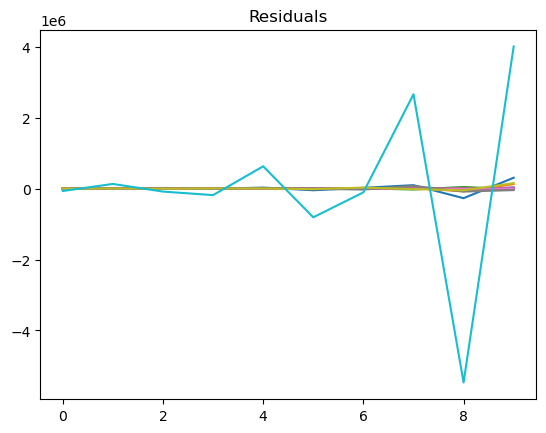

Durbin-Watson statistic for Enteric Fermentation: 2.69939037650087
Durbin-Watson statistic for Manure Management: 2.29003824365793
Durbin-Watson statistic for Synthetic Fertilizers: 3.2528381898002094
Durbin-Watson statistic for Manure applied to Soils: 2.935032029495343
Durbin-Watson statistic for Manure left on Pasture: 2.9350060468537054
Durbin-Watson statistic for Crop Residues: 2.9258448862987865
Durbin-Watson statistic for Burning - Crop residues: 2.376988605651661
Durbin-Watson statistic for IPCC Agriculture: 2.5078864678359007
Durbin-Watson statistic for Agricultural Soils: 1.6980089862229761
Durbin-Watson statistic for Asses: 3.0803183310980033


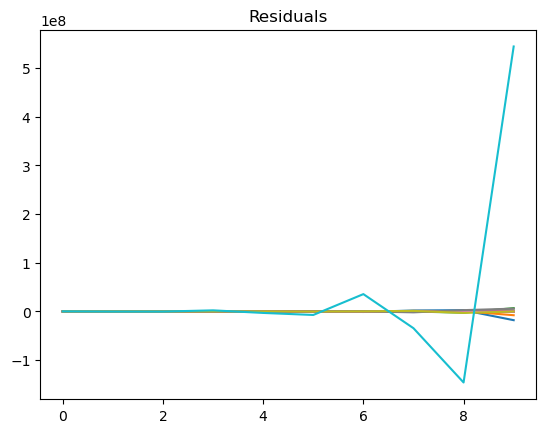

Durbin-Watson statistic for Enteric Fermentation: 1.2952553318241644
Durbin-Watson statistic for Manure Management: 1.1717432057627855
Durbin-Watson statistic for Synthetic Fertilizers: 1.76319026964852
Durbin-Watson statistic for Manure applied to Soils: 1.428111027391843
Durbin-Watson statistic for Manure left on Pasture: 1.1052123533627456
Durbin-Watson statistic for Crop Residues: 1.525860926975704
Durbin-Watson statistic for Burning - Crop residues: 2.145369399827538
Durbin-Watson statistic for IPCC Agriculture: 0.791283374780347
Durbin-Watson statistic for Agricultural Soils: 2.5486581302643088
Durbin-Watson statistic for Barley: 1.5484911956642267


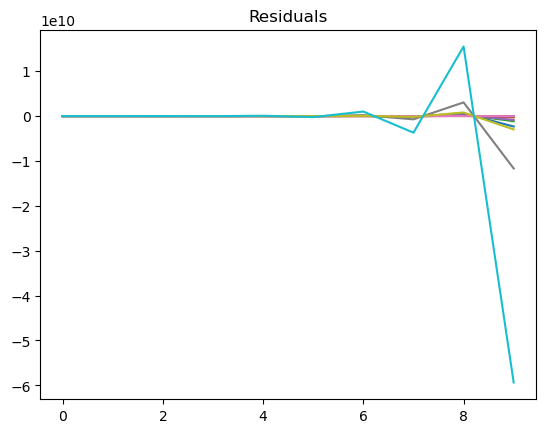

Durbin-Watson statistic for Enteric Fermentation: 1.5913955267879138
Durbin-Watson statistic for Manure Management: 1.5921249960552835
Durbin-Watson statistic for Synthetic Fertilizers: 1.6362547859748258
Durbin-Watson statistic for Manure applied to Soils: 1.6236204892393604
Durbin-Watson statistic for Manure left on Pasture: 1.5942688995112284
Durbin-Watson statistic for Crop Residues: 1.616176088962997
Durbin-Watson statistic for Burning - Crop residues: 1.615312387087159
Durbin-Watson statistic for IPCC Agriculture: 1.5869517952717225
Durbin-Watson statistic for Agricultural Soils: 1.6097047282045627
Durbin-Watson statistic for Beans, dry: 1.5871636478403846


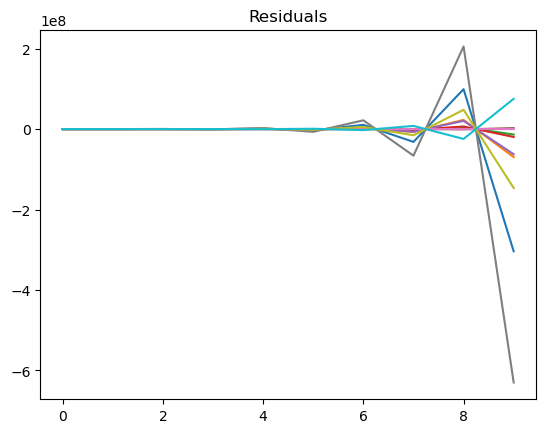

Durbin-Watson statistic for Enteric Fermentation: 1.7578898476164952
Durbin-Watson statistic for Manure Management: 1.7574812829264426
Durbin-Watson statistic for Synthetic Fertilizers: 1.7673867949196096
Durbin-Watson statistic for Manure applied to Soils: 1.758318015481399
Durbin-Watson statistic for Manure left on Pasture: 1.7581503943048389
Durbin-Watson statistic for Crop Residues: 1.7549675581991346
Durbin-Watson statistic for Burning - Crop residues: 1.769460774804746
Durbin-Watson statistic for IPCC Agriculture: 1.7572693553183392
Durbin-Watson statistic for Agricultural Soils: 1.7583917552309576
Durbin-Watson statistic for Beef and Buffalo Meat: 1.7562905770814308


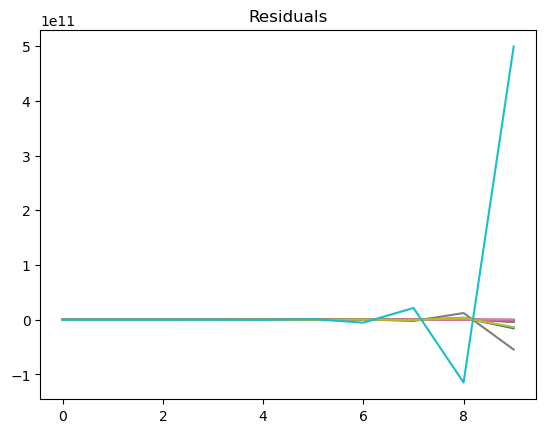

Durbin-Watson statistic for Enteric Fermentation: 1.4890990934689965
Durbin-Watson statistic for Manure Management: 1.4863609925858776
Durbin-Watson statistic for Synthetic Fertilizers: 1.5355830449467402
Durbin-Watson statistic for Manure applied to Soils: 1.4931925623761417
Durbin-Watson statistic for Manure left on Pasture: 1.492837672359357
Durbin-Watson statistic for Crop Residues: 1.7184445805351105
Durbin-Watson statistic for Burning - Crop residues: 1.5865817166624039
Durbin-Watson statistic for IPCC Agriculture: 1.4907088400081343
Durbin-Watson statistic for Agricultural Soils: 1.5035209562101948
Durbin-Watson statistic for Beehives: 1.5073736452639848


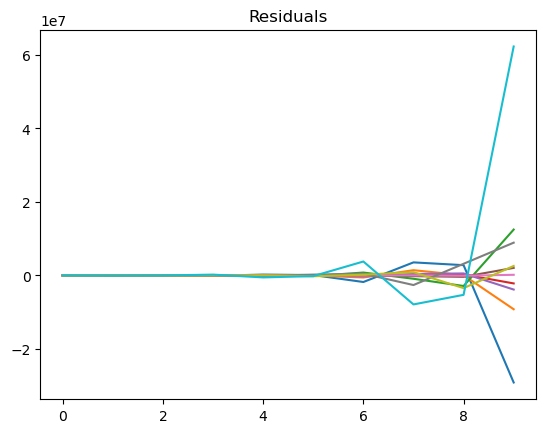

Durbin-Watson statistic for Enteric Fermentation: 1.206567291272413
Durbin-Watson statistic for Manure Management: 1.0556421480740497
Durbin-Watson statistic for Synthetic Fertilizers: 1.4697959449594575
Durbin-Watson statistic for Manure applied to Soils: 1.264395363915716
Durbin-Watson statistic for Manure left on Pasture: 1.2968500073243796
Durbin-Watson statistic for Crop Residues: 1.3709132791735779
Durbin-Watson statistic for Burning - Crop residues: 1.8633338978149439
Durbin-Watson statistic for IPCC Agriculture: 0.7872797187008714
Durbin-Watson statistic for Agricultural Soils: 2.872641043179104
Durbin-Watson statistic for Buffaloes: 1.1856623361398704


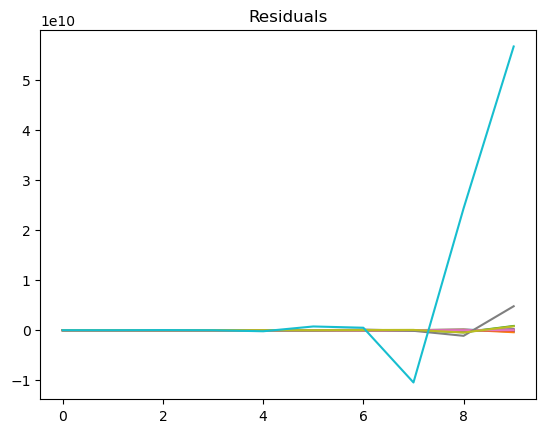

Durbin-Watson statistic for Enteric Fermentation: 1.9373652296321844
Durbin-Watson statistic for Manure Management: 1.5189589870424711
Durbin-Watson statistic for Synthetic Fertilizers: 2.0497590439224362
Durbin-Watson statistic for Manure applied to Soils: 1.9539849494603025
Durbin-Watson statistic for Manure left on Pasture: 1.5311374734791017
Durbin-Watson statistic for Crop Residues: 1.948683099368316
Durbin-Watson statistic for Burning - Crop residues: 2.4152066229584648
Durbin-Watson statistic for IPCC Agriculture: 1.4901430018022934
Durbin-Watson statistic for Agricultural Soils: 2.207390016318683
Durbin-Watson statistic for Cattle: 0.607151339506796


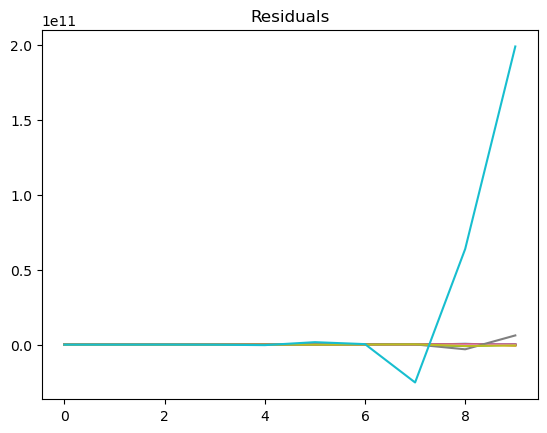

Durbin-Watson statistic for Enteric Fermentation: 2.7368215661385933
Durbin-Watson statistic for Manure Management: 2.148926353509775
Durbin-Watson statistic for Synthetic Fertilizers: 2.3764580115913323
Durbin-Watson statistic for Manure applied to Soils: 2.814499673462043
Durbin-Watson statistic for Manure left on Pasture: 2.103193799817036
Durbin-Watson statistic for Crop Residues: 2.754946201121661
Durbin-Watson statistic for Burning - Crop residues: 0.9339251849142738
Durbin-Watson statistic for IPCC Agriculture: 2.0291657110625394
Durbin-Watson statistic for Agricultural Soils: 1.2379323172688448
Durbin-Watson statistic for Cattle and Buffaloes: 0.6061041918258272


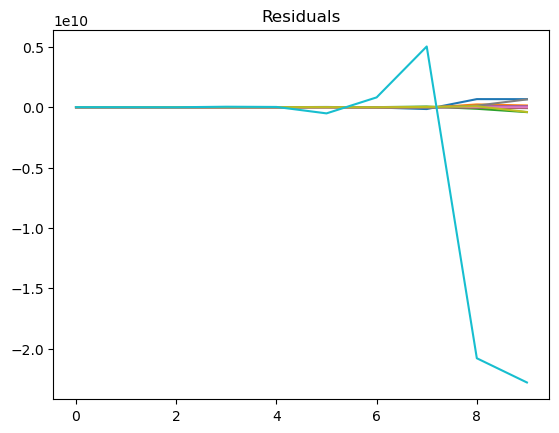

Durbin-Watson statistic for Enteric Fermentation: 0.7649300313366335
Durbin-Watson statistic for Manure Management: 1.141458965919014
Durbin-Watson statistic for Synthetic Fertilizers: 0.601650634567481
Durbin-Watson statistic for Manure applied to Soils: 0.6971737340990551
Durbin-Watson statistic for Manure left on Pasture: 0.7399017739335592
Durbin-Watson statistic for Crop Residues: 0.5585139156152102
Durbin-Watson statistic for Burning - Crop residues: 0.6130748942352867
Durbin-Watson statistic for IPCC Agriculture: 0.7131170249154065
Durbin-Watson statistic for Agricultural Soils: 1.3810244896678172
Durbin-Watson statistic for Cereals, Total: 0.7057564910345356


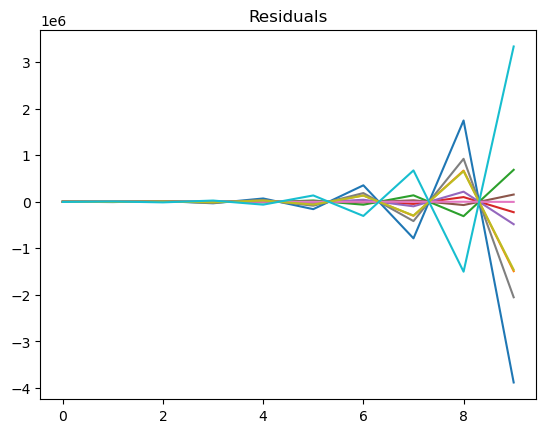

Durbin-Watson statistic for Enteric Fermentation: 2.1022233414792497
Durbin-Watson statistic for Manure Management: 2.102149025646916
Durbin-Watson statistic for Synthetic Fertilizers: 2.1020506204385994
Durbin-Watson statistic for Manure applied to Soils: 2.1022545283073075
Durbin-Watson statistic for Manure left on Pasture: 2.1023222710563294
Durbin-Watson statistic for Crop Residues: 2.10224477062577
Durbin-Watson statistic for Burning - Crop residues: 2.099877362485615
Durbin-Watson statistic for IPCC Agriculture: 2.102780139938317
Durbin-Watson statistic for Agricultural Soils: 2.102224170710079
Durbin-Watson statistic for Chickens: 2.1022747783312


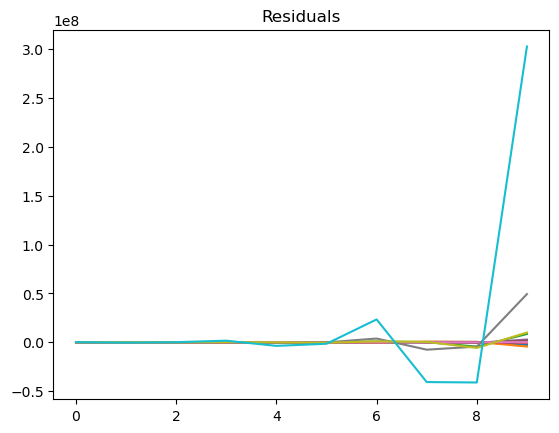

Durbin-Watson statistic for Enteric Fermentation: 1.2900340423492966
Durbin-Watson statistic for Manure Management: 1.1920237548698775
Durbin-Watson statistic for Synthetic Fertilizers: 2.0704666260558082
Durbin-Watson statistic for Manure applied to Soils: 1.3449768826053663
Durbin-Watson statistic for Manure left on Pasture: 1.4248618582006232
Durbin-Watson statistic for Crop Residues: 1.618339066856373
Durbin-Watson statistic for Burning - Crop residues: 1.8879750640559048
Durbin-Watson statistic for IPCC Agriculture: 1.2071720187624069
Durbin-Watson statistic for Agricultural Soils: 2.1486539964725844
Durbin-Watson statistic for Eggs Primary: 1.2873436078409315


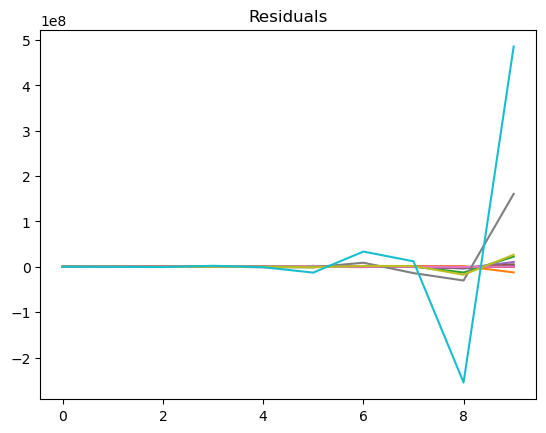

Durbin-Watson statistic for Enteric Fermentation: 2.8593867088708307
Durbin-Watson statistic for Manure Management: 1.227761633601705
Durbin-Watson statistic for Synthetic Fertilizers: 2.1210825981617494
Durbin-Watson statistic for Manure applied to Soils: 1.047184320042575
Durbin-Watson statistic for Manure left on Pasture: 1.6456463541039916
Durbin-Watson statistic for Crop Residues: 1.7221929080424048
Durbin-Watson statistic for Burning - Crop residues: 1.9877708571685488
Durbin-Watson statistic for IPCC Agriculture: 1.381594846154141
Durbin-Watson statistic for Agricultural Soils: 2.2675116475293478
Durbin-Watson statistic for Eggs, hen, in shell: 2.0594710514219936


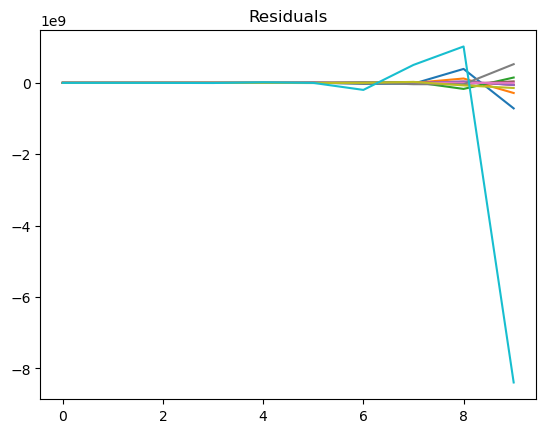

Durbin-Watson statistic for Enteric Fermentation: 2.0977876837748144
Durbin-Watson statistic for Manure Management: 1.8903488214498232
Durbin-Watson statistic for Synthetic Fertilizers: 2.6943703190624113
Durbin-Watson statistic for Manure applied to Soils: 2.154316338820865
Durbin-Watson statistic for Manure left on Pasture: 2.2330481096941326
Durbin-Watson statistic for Crop Residues: 2.386910089489572
Durbin-Watson statistic for Burning - Crop residues: 2.842910554569966
Durbin-Watson statistic for IPCC Agriculture: 1.146580249344113
Durbin-Watson statistic for Agricultural Soils: 0.5973921500494725
Durbin-Watson statistic for Fruit Primary: 1.2454817721454274


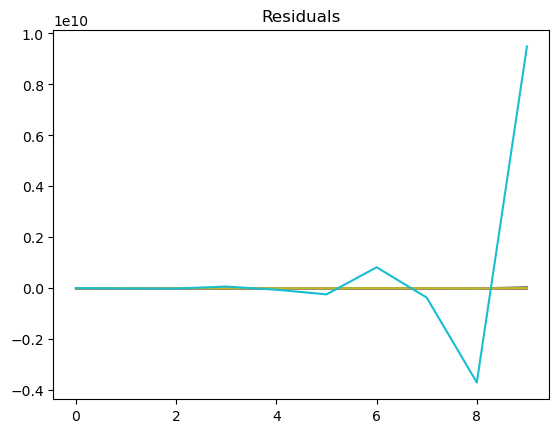

Durbin-Watson statistic for Enteric Fermentation: 0.8473934813898532
Durbin-Watson statistic for Manure Management: 1.0768750465345087
Durbin-Watson statistic for Synthetic Fertilizers: 2.3398916323015846
Durbin-Watson statistic for Manure applied to Soils: 0.9421994115587544
Durbin-Watson statistic for Manure left on Pasture: 2.030515841106416
Durbin-Watson statistic for Crop Residues: 1.7088398558571145
Durbin-Watson statistic for Burning - Crop residues: 1.9230968355872962
Durbin-Watson statistic for IPCC Agriculture: 1.4831148735032011
Durbin-Watson statistic for Agricultural Soils: 2.7033440264782174
Durbin-Watson statistic for Goats: 1.7933628753569764


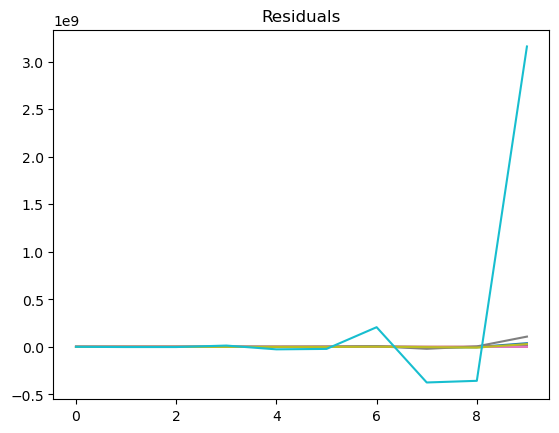

Durbin-Watson statistic for Enteric Fermentation: 1.1003950342983289
Durbin-Watson statistic for Manure Management: 1.5604021605588263
Durbin-Watson statistic for Synthetic Fertilizers: 1.498846831297984
Durbin-Watson statistic for Manure applied to Soils: 1.0469700476424282
Durbin-Watson statistic for Manure left on Pasture: 1.101352779681847
Durbin-Watson statistic for Crop Residues: 1.585198897703974
Durbin-Watson statistic for Burning - Crop residues: 2.624136026091367
Durbin-Watson statistic for IPCC Agriculture: 0.985436061235846
Durbin-Watson statistic for Agricultural Soils: 1.4364756235510703
Durbin-Watson statistic for Grapes: 1.2391230116000367


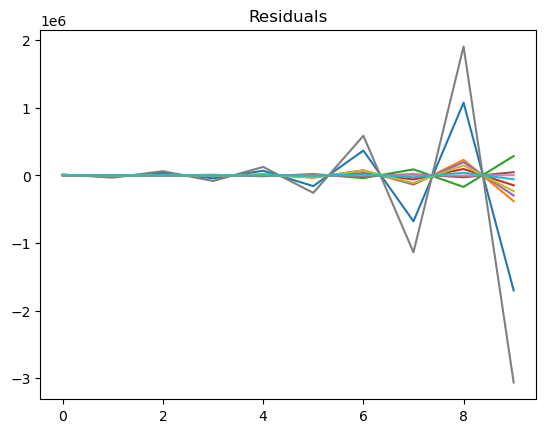

Durbin-Watson statistic for Enteric Fermentation: 2.613946147629491
Durbin-Watson statistic for Manure Management: 2.5340285794975195
Durbin-Watson statistic for Synthetic Fertilizers: 2.4597347816102357
Durbin-Watson statistic for Manure applied to Soils: 2.6342136024604077
Durbin-Watson statistic for Manure left on Pasture: 2.68630816161743
Durbin-Watson statistic for Crop Residues: 2.4819616093220884
Durbin-Watson statistic for Burning - Crop residues: 2.6542158164356606
Durbin-Watson statistic for IPCC Agriculture: 2.567546973093324
Durbin-Watson statistic for Agricultural Soils: 2.7257287039310145
Durbin-Watson statistic for Hides, cattle, fresh: 2.7494081806721793


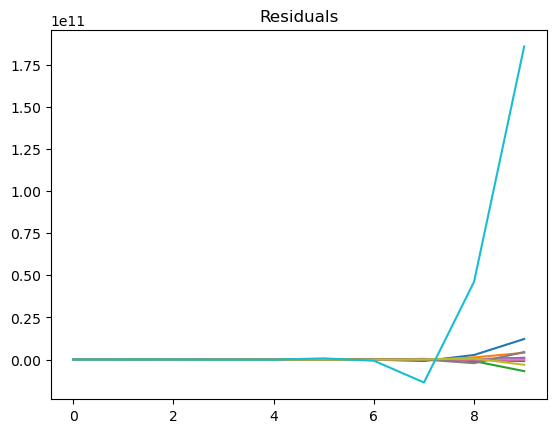

Durbin-Watson statistic for Enteric Fermentation: 0.6590589930563581
Durbin-Watson statistic for Manure Management: 0.5705061662827534
Durbin-Watson statistic for Synthetic Fertilizers: 0.7726818023430279
Durbin-Watson statistic for Manure applied to Soils: 0.7352739753655351
Durbin-Watson statistic for Manure left on Pasture: 0.718902575919419
Durbin-Watson statistic for Crop Residues: 0.7312772805277462
Durbin-Watson statistic for Burning - Crop residues: 0.9432561398494458
Durbin-Watson statistic for IPCC Agriculture: 1.9612005971952007
Durbin-Watson statistic for Agricultural Soils: 1.457015312427247
Durbin-Watson statistic for Horses: 0.6306871657782949


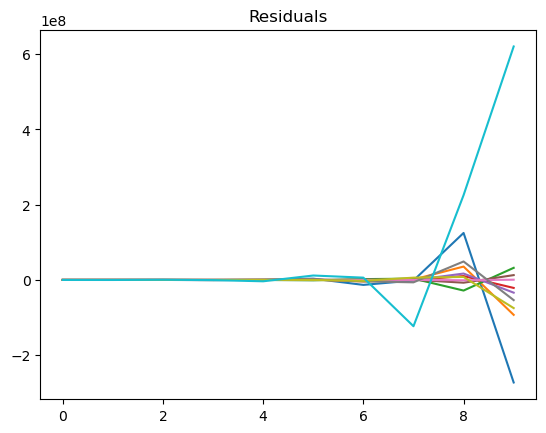

Durbin-Watson statistic for Enteric Fermentation: 1.935755879409342
Durbin-Watson statistic for Manure Management: 1.7894276826637072
Durbin-Watson statistic for Synthetic Fertilizers: 2.5216648280652465
Durbin-Watson statistic for Manure applied to Soils: 1.9877570241861988
Durbin-Watson statistic for Manure left on Pasture: 2.0176385121408895
Durbin-Watson statistic for Crop Residues: 2.131836703370266
Durbin-Watson statistic for Burning - Crop residues: 2.7861151186074844
Durbin-Watson statistic for IPCC Agriculture: 2.5571121657817284
Durbin-Watson statistic for Agricultural Soils: 1.2159341642708703
Durbin-Watson statistic for Maize: 0.6526928129856576


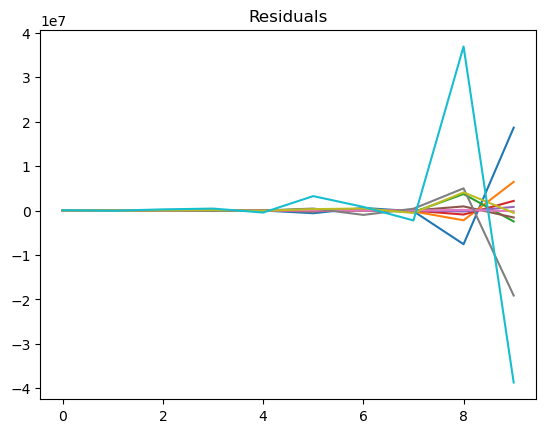

Durbin-Watson statistic for Enteric Fermentation: 1.8369006205943534
Durbin-Watson statistic for Manure Management: 1.7027688380102015
Durbin-Watson statistic for Synthetic Fertilizers: 2.746589262900804
Durbin-Watson statistic for Manure applied to Soils: 1.8620408625014355
Durbin-Watson statistic for Manure left on Pasture: 1.6294549616666392
Durbin-Watson statistic for Crop Residues: 2.128746991552315
Durbin-Watson statistic for Burning - Crop residues: 2.400484473746723
Durbin-Watson statistic for IPCC Agriculture: 1.5467957514567376
Durbin-Watson statistic for Agricultural Soils: 2.5030942110695205
Durbin-Watson statistic for Meat, Poultry: 2.5305275698490424


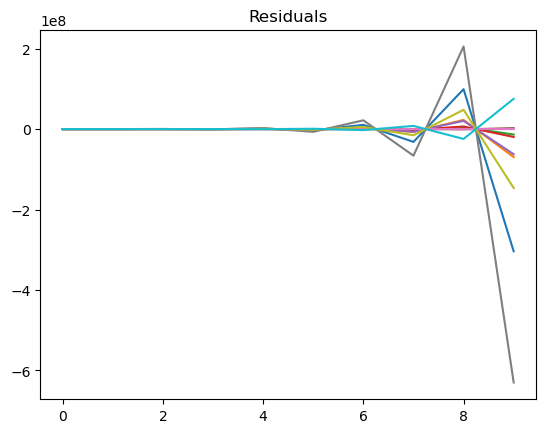

Durbin-Watson statistic for Enteric Fermentation: 1.7578898476164952
Durbin-Watson statistic for Manure Management: 1.7574812829264426
Durbin-Watson statistic for Synthetic Fertilizers: 1.7673867949196096
Durbin-Watson statistic for Manure applied to Soils: 1.758318015481399
Durbin-Watson statistic for Manure left on Pasture: 1.7581503943048389
Durbin-Watson statistic for Crop Residues: 1.7549675581991346
Durbin-Watson statistic for Burning - Crop residues: 1.769460774804746
Durbin-Watson statistic for IPCC Agriculture: 1.7572693553183392
Durbin-Watson statistic for Agricultural Soils: 1.7583917552309576
Durbin-Watson statistic for Meat, cattle: 1.7562905770814308


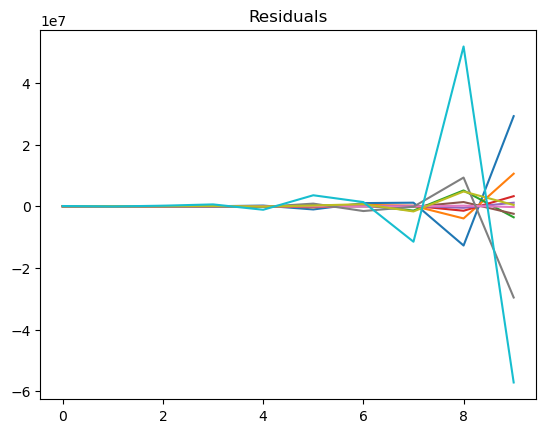

Durbin-Watson statistic for Enteric Fermentation: 1.9213201512742635
Durbin-Watson statistic for Manure Management: 1.789355657405686
Durbin-Watson statistic for Synthetic Fertilizers: 2.9462948204908255
Durbin-Watson statistic for Manure applied to Soils: 1.9380226833192384
Durbin-Watson statistic for Manure left on Pasture: 1.9627223982576947
Durbin-Watson statistic for Crop Residues: 2.153606535512204
Durbin-Watson statistic for Burning - Crop residues: 2.466119218891163
Durbin-Watson statistic for IPCC Agriculture: 1.66935471981703
Durbin-Watson statistic for Agricultural Soils: 2.5282696578644437
Durbin-Watson statistic for Meat, chicken: 2.636026024639339


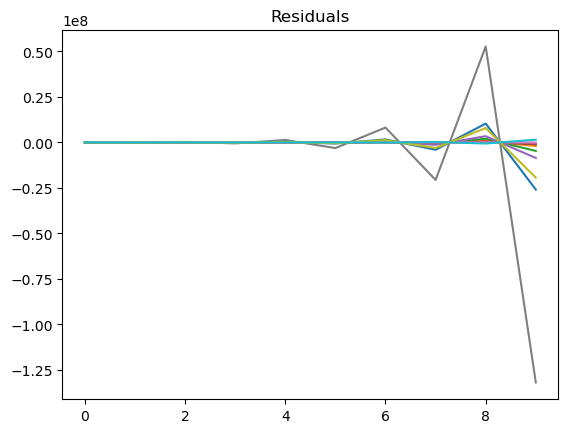

Durbin-Watson statistic for Enteric Fermentation: 1.95502367510703
Durbin-Watson statistic for Manure Management: 1.9593618621571836
Durbin-Watson statistic for Synthetic Fertilizers: 2.0207246536790966
Durbin-Watson statistic for Manure applied to Soils: 1.9527975385569043
Durbin-Watson statistic for Manure left on Pasture: 1.9567843908460145
Durbin-Watson statistic for Crop Residues: 1.9803829948008969
Durbin-Watson statistic for Burning - Crop residues: 2.0448726448529366
Durbin-Watson statistic for IPCC Agriculture: 1.9553935282510528
Durbin-Watson statistic for Agricultural Soils: 1.9746173787704986
Durbin-Watson statistic for Meat, goat: 1.9632496062240627


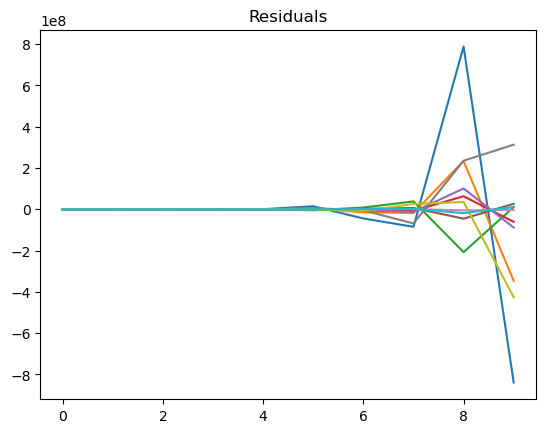

Durbin-Watson statistic for Enteric Fermentation: 2.5595013821397847
Durbin-Watson statistic for Manure Management: 2.285979441563815
Durbin-Watson statistic for Synthetic Fertilizers: 2.442907557034247
Durbin-Watson statistic for Manure applied to Soils: 2.63136446824548
Durbin-Watson statistic for Manure left on Pasture: 2.6830571079948538
Durbin-Watson statistic for Crop Residues: 2.8068188925230264
Durbin-Watson statistic for Burning - Crop residues: 1.3265533072238989
Durbin-Watson statistic for IPCC Agriculture: 0.6481984473862922
Durbin-Watson statistic for Agricultural Soils: 1.1690319907372484
Durbin-Watson statistic for Meat, pig: 2.8048336659073896


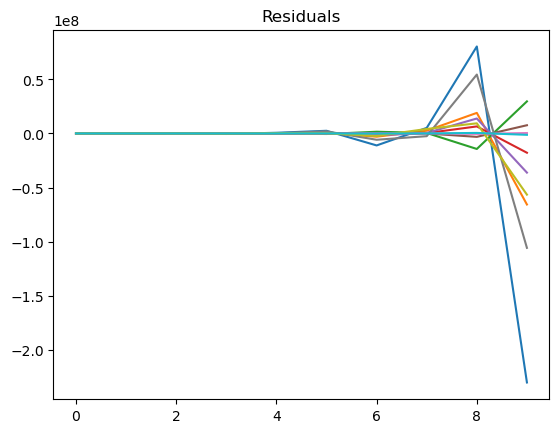

Durbin-Watson statistic for Enteric Fermentation: 1.7209330823929962
Durbin-Watson statistic for Manure Management: 1.596129278147873
Durbin-Watson statistic for Synthetic Fertilizers: 1.98561070250714
Durbin-Watson statistic for Manure applied to Soils: 1.753613673227416
Durbin-Watson statistic for Manure left on Pasture: 1.788180315327493
Durbin-Watson statistic for Crop Residues: 1.8501465379333841
Durbin-Watson statistic for Burning - Crop residues: 2.6589407849180797
Durbin-Watson statistic for IPCC Agriculture: 2.042009024226694
Durbin-Watson statistic for Agricultural Soils: 1.3358326349398983
Durbin-Watson statistic for Meat, sheep: 1.7907111397130222


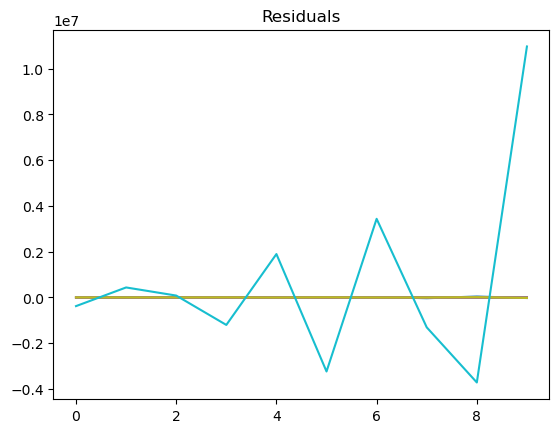

Durbin-Watson statistic for Enteric Fermentation: 3.4520780682063767
Durbin-Watson statistic for Manure Management: 3.0057311163045646
Durbin-Watson statistic for Synthetic Fertilizers: 2.731498824088722
Durbin-Watson statistic for Manure applied to Soils: 3.53836773495851
Durbin-Watson statistic for Manure left on Pasture: 3.547849704108082
Durbin-Watson statistic for Crop Residues: 3.4490725669711666
Durbin-Watson statistic for Burning - Crop residues: 1.9754251678813894
Durbin-Watson statistic for IPCC Agriculture: 2.415480093485759
Durbin-Watson statistic for Agricultural Soils: 2.290018993296677
Durbin-Watson statistic for Milk, Total: 1.9991842667890884


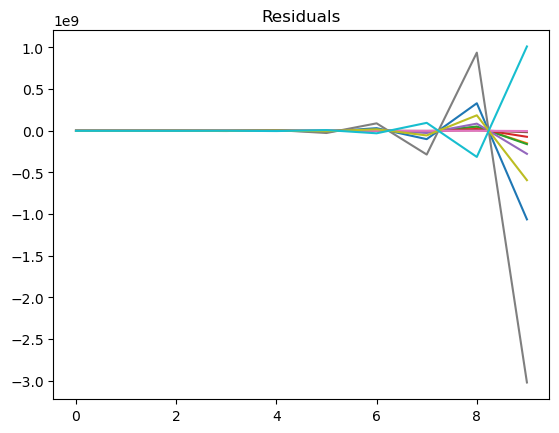

Durbin-Watson statistic for Enteric Fermentation: 1.7172219314018016
Durbin-Watson statistic for Manure Management: 1.716807426158392
Durbin-Watson statistic for Synthetic Fertilizers: 1.7363879534860618
Durbin-Watson statistic for Manure applied to Soils: 1.7176808853987733
Durbin-Watson statistic for Manure left on Pasture: 1.718109796470645
Durbin-Watson statistic for Crop Residues: 1.7334644118750748
Durbin-Watson statistic for Burning - Crop residues: 1.7274306653381424
Durbin-Watson statistic for IPCC Agriculture: 1.7161577610256225
Durbin-Watson statistic for Agricultural Soils: 1.7230391715164317
Durbin-Watson statistic for Milk, whole fresh buffalo: 1.7144241515542809


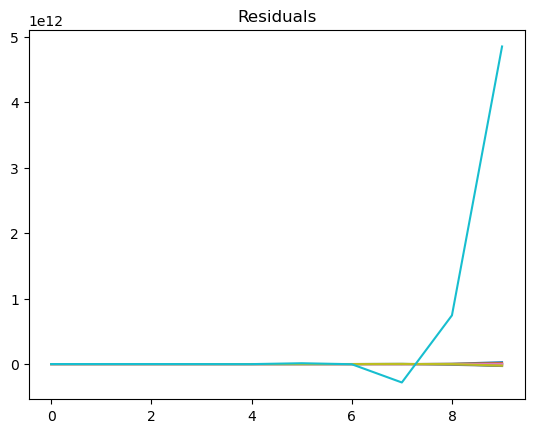

Durbin-Watson statistic for Enteric Fermentation: 0.7366714696091486
Durbin-Watson statistic for Manure Management: 0.6519956200519055
Durbin-Watson statistic for Synthetic Fertilizers: 0.8406700654912511
Durbin-Watson statistic for Manure applied to Soils: 0.7688477758663014
Durbin-Watson statistic for Manure left on Pasture: 1.2849264458335194
Durbin-Watson statistic for Crop Residues: 0.8026391634084178
Durbin-Watson statistic for Burning - Crop residues: 0.9302131965431764
Durbin-Watson statistic for IPCC Agriculture: 0.5262963341927923
Durbin-Watson statistic for Agricultural Soils: 0.9651890855160475
Durbin-Watson statistic for Milk, whole fresh cow: 0.7447911544648564


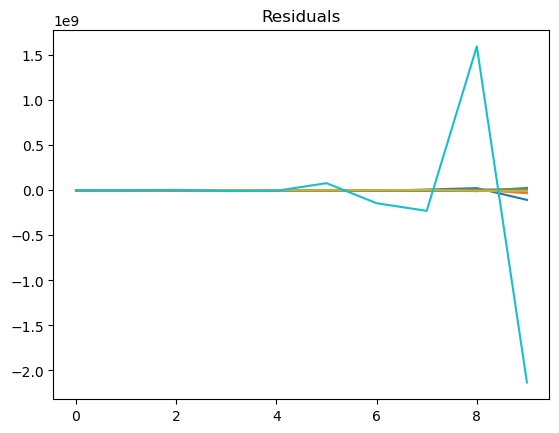

Durbin-Watson statistic for Enteric Fermentation: 1.4509884151546422
Durbin-Watson statistic for Manure Management: 1.3342653101229742
Durbin-Watson statistic for Synthetic Fertilizers: 1.8009350598711962
Durbin-Watson statistic for Manure applied to Soils: 1.4787551681980866
Durbin-Watson statistic for Manure left on Pasture: 1.5207710911011345
Durbin-Watson statistic for Crop Residues: 1.5758450693237251
Durbin-Watson statistic for Burning - Crop residues: 1.9440134553606352
Durbin-Watson statistic for IPCC Agriculture: 0.7949446444109565
Durbin-Watson statistic for Agricultural Soils: 0.8882809721193894
Durbin-Watson statistic for Milk, whole fresh goat: 2.4101967550628993


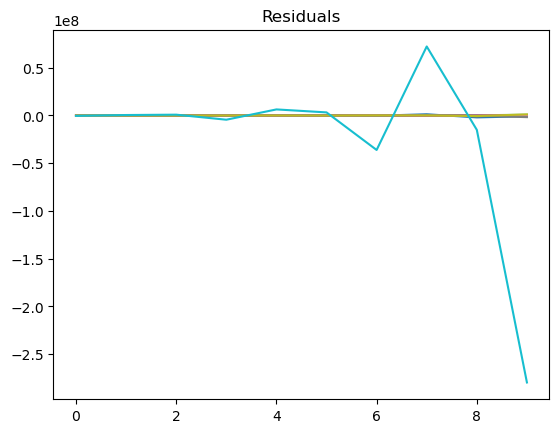

Durbin-Watson statistic for Enteric Fermentation: 2.2678200854084953
Durbin-Watson statistic for Manure Management: 3.0944552484464567
Durbin-Watson statistic for Synthetic Fertilizers: 1.0295203383428229
Durbin-Watson statistic for Manure applied to Soils: 1.9148094777922984
Durbin-Watson statistic for Manure left on Pasture: 1.630201309494925
Durbin-Watson statistic for Crop Residues: 1.4575064298729208
Durbin-Watson statistic for Burning - Crop residues: 1.0384056122222514
Durbin-Watson statistic for IPCC Agriculture: 1.0219478661969033
Durbin-Watson statistic for Agricultural Soils: 2.055433286753674
Durbin-Watson statistic for Milk, whole fresh sheep: 1.0713598772790527


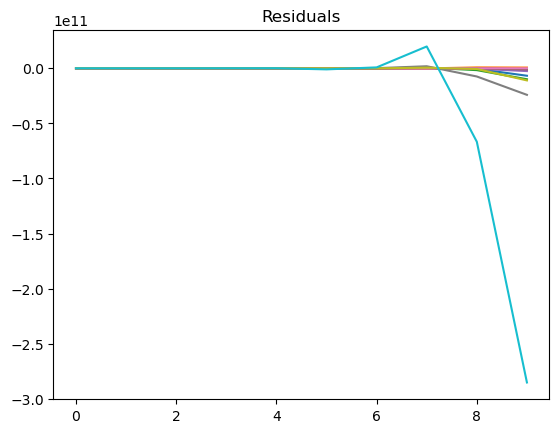

Durbin-Watson statistic for Enteric Fermentation: 0.8638729450738998
Durbin-Watson statistic for Manure Management: 0.7980459003237182
Durbin-Watson statistic for Synthetic Fertilizers: 0.7259941587635015
Durbin-Watson statistic for Manure applied to Soils: 0.6635793410189158
Durbin-Watson statistic for Manure left on Pasture: 0.717642837065439
Durbin-Watson statistic for Crop Residues: 0.7143863846011654
Durbin-Watson statistic for Burning - Crop residues: 2.2966478503532213
Durbin-Watson statistic for IPCC Agriculture: 0.5744399243468062
Durbin-Watson statistic for Agricultural Soils: 0.9007531199078783
Durbin-Watson statistic for Oats: 0.645134612933815


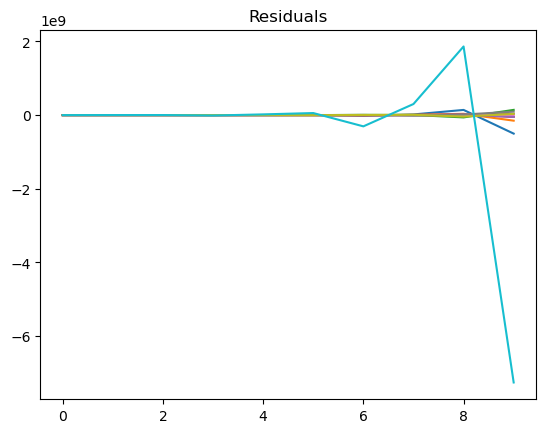

Durbin-Watson statistic for Enteric Fermentation: 1.5753322612776761
Durbin-Watson statistic for Manure Management: 1.4736309950310797
Durbin-Watson statistic for Synthetic Fertilizers: 1.9187390563400775
Durbin-Watson statistic for Manure applied to Soils: 1.5623673942558445
Durbin-Watson statistic for Manure left on Pasture: 1.6891802121353712
Durbin-Watson statistic for Crop Residues: 1.6863763236751288
Durbin-Watson statistic for Burning - Crop residues: 1.901842376336501
Durbin-Watson statistic for IPCC Agriculture: 0.8060279165353711
Durbin-Watson statistic for Agricultural Soils: 2.807314964685478
Durbin-Watson statistic for Olives: 1.5287191241307205


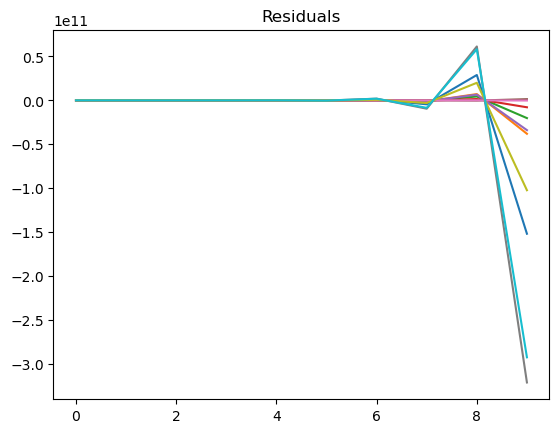

Durbin-Watson statistic for Enteric Fermentation: 1.414008912829744
Durbin-Watson statistic for Manure Management: 1.4097134744570456
Durbin-Watson statistic for Synthetic Fertilizers: 1.4767716884024018
Durbin-Watson statistic for Manure applied to Soils: 1.4167670461418727
Durbin-Watson statistic for Manure left on Pasture: 1.4175714455601374
Durbin-Watson statistic for Crop Residues: 1.3464029934159079
Durbin-Watson statistic for Burning - Crop residues: 1.4261977771608676
Durbin-Watson statistic for IPCC Agriculture: 1.4155742406351224
Durbin-Watson statistic for Agricultural Soils: 1.425529670070362
Durbin-Watson statistic for Other paper and paperboard: 1.433095241279827


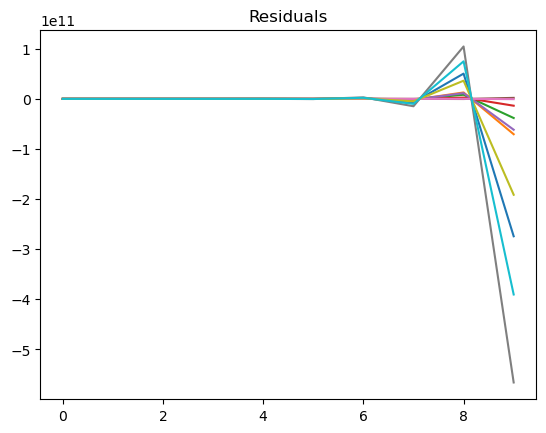

Durbin-Watson statistic for Enteric Fermentation: 1.3983608948216817
Durbin-Watson statistic for Manure Management: 1.3931069692812401
Durbin-Watson statistic for Synthetic Fertilizers: 1.467800377553944
Durbin-Watson statistic for Manure applied to Soils: 1.402506308668426
Durbin-Watson statistic for Manure left on Pasture: 1.4025092603076283
Durbin-Watson statistic for Crop Residues: 1.3022245376354908
Durbin-Watson statistic for Burning - Crop residues: 1.4075065041240258
Durbin-Watson statistic for IPCC Agriculture: 1.4003046876419125
Durbin-Watson statistic for Agricultural Soils: 1.4108015028125904
Durbin-Watson statistic for Other paper and paperboard n.e.s. (not elsewhere specified): 1.4158538541762822


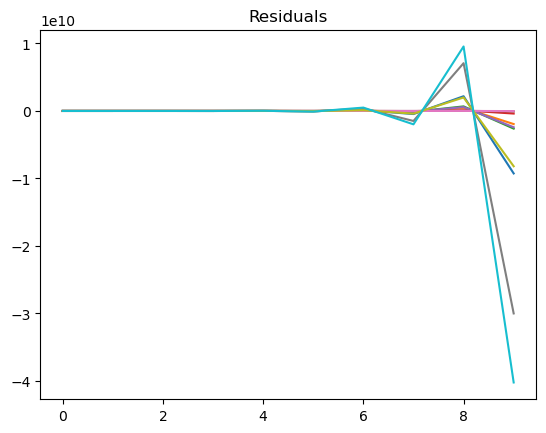

Durbin-Watson statistic for Enteric Fermentation: 1.5238975836374213
Durbin-Watson statistic for Manure Management: 1.5208371272312462
Durbin-Watson statistic for Synthetic Fertilizers: 1.573829602555424
Durbin-Watson statistic for Manure applied to Soils: 1.525897211001724
Durbin-Watson statistic for Manure left on Pasture: 1.5279183783645909
Durbin-Watson statistic for Crop Residues: 1.6737829155581916
Durbin-Watson statistic for Burning - Crop residues: 1.5677520977850794
Durbin-Watson statistic for IPCC Agriculture: 1.5242488587308272
Durbin-Watson statistic for Agricultural Soils: 1.5413081943700742
Durbin-Watson statistic for Paper and paperboard: 1.5275364458191194


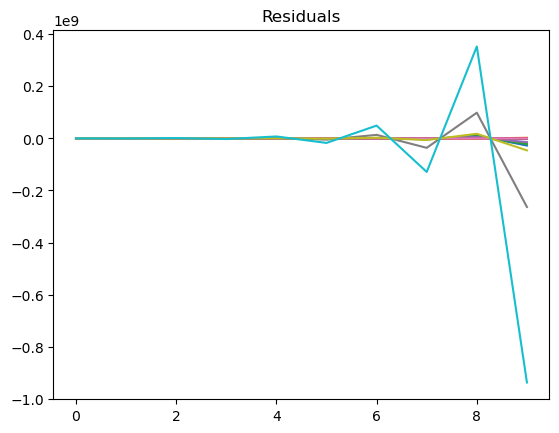

Durbin-Watson statistic for Enteric Fermentation: 1.8825135665008728
Durbin-Watson statistic for Manure Management: 1.8927164165978447
Durbin-Watson statistic for Synthetic Fertilizers: 1.9207147449661306
Durbin-Watson statistic for Manure applied to Soils: 1.9339837798220123
Durbin-Watson statistic for Manure left on Pasture: 1.888931975394447
Durbin-Watson statistic for Crop Residues: 1.9127149105154686
Durbin-Watson statistic for Burning - Crop residues: 1.9278727806069509
Durbin-Watson statistic for IPCC Agriculture: 1.8870566988794952
Durbin-Watson statistic for Agricultural Soils: 1.9062260451155995
Durbin-Watson statistic for Paper and paperboard, excluding newsprint: 1.8911117364619798


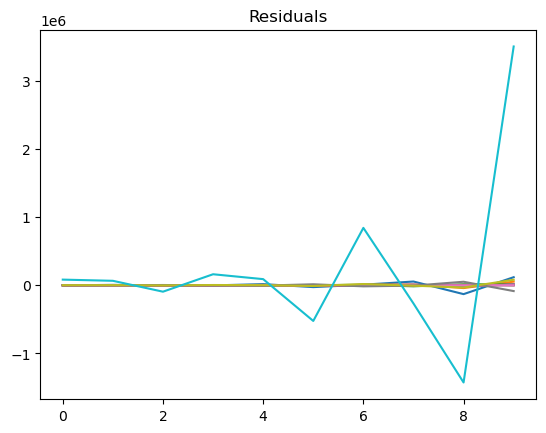

Durbin-Watson statistic for Enteric Fermentation: 2.9022414359514617
Durbin-Watson statistic for Manure Management: 2.5331027448842454
Durbin-Watson statistic for Synthetic Fertilizers: 2.129083857969176
Durbin-Watson statistic for Manure applied to Soils: 3.0170038087455455
Durbin-Watson statistic for Manure left on Pasture: 3.140080174032504
Durbin-Watson statistic for Crop Residues: 3.1988544161388495
Durbin-Watson statistic for Burning - Crop residues: 1.7357119955084637
Durbin-Watson statistic for IPCC Agriculture: 2.236785264917026
Durbin-Watson statistic for Agricultural Soils: 1.8780975606766064
Durbin-Watson statistic for Pigs: 1.8949903906626016


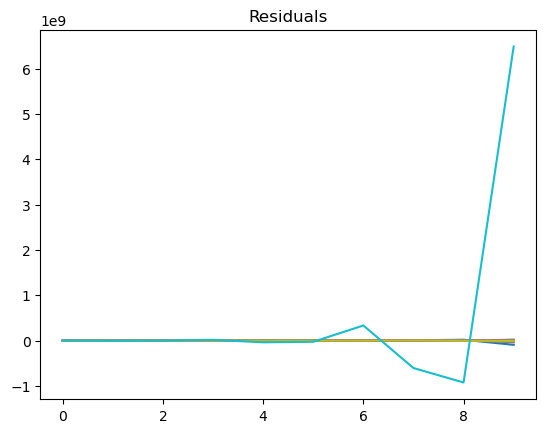

Durbin-Watson statistic for Enteric Fermentation: 1.3884555232952356
Durbin-Watson statistic for Manure Management: 1.2753585812044173
Durbin-Watson statistic for Synthetic Fertilizers: 1.6506923646584455
Durbin-Watson statistic for Manure applied to Soils: 1.416185576475138
Durbin-Watson statistic for Manure left on Pasture: 1.4445149722691968
Durbin-Watson statistic for Crop Residues: 1.5005765473302082
Durbin-Watson statistic for Burning - Crop residues: 1.809788727769937
Durbin-Watson statistic for IPCC Agriculture: 1.8320415402282073
Durbin-Watson statistic for Agricultural Soils: 0.753837359854559
Durbin-Watson statistic for Potatoes: 1.2907232466435021


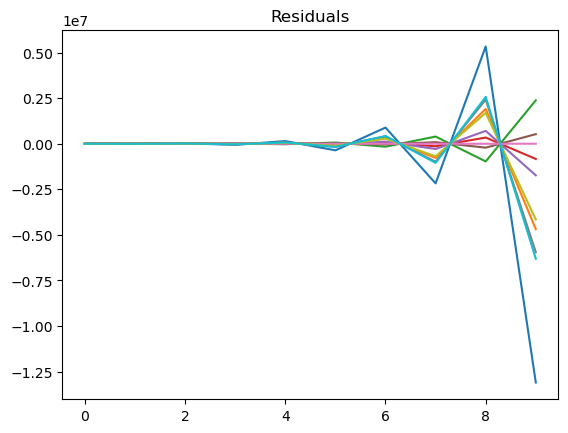

Durbin-Watson statistic for Enteric Fermentation: 1.980916202968127
Durbin-Watson statistic for Manure Management: 1.9808929968263724
Durbin-Watson statistic for Synthetic Fertilizers: 1.9808841750691584
Durbin-Watson statistic for Manure applied to Soils: 1.9809345897656507
Durbin-Watson statistic for Manure left on Pasture: 1.9809280548761752
Durbin-Watson statistic for Crop Residues: 1.9809332581987462
Durbin-Watson statistic for Burning - Crop residues: 1.983028814487075
Durbin-Watson statistic for IPCC Agriculture: 1.9811338016843654
Durbin-Watson statistic for Agricultural Soils: 1.9808890689222711
Durbin-Watson statistic for Poultry Birds: 1.9809732297492946


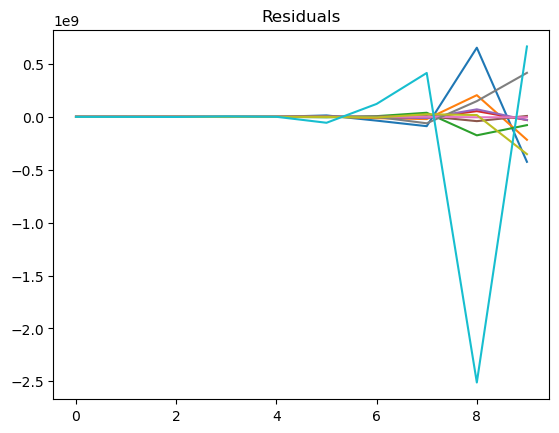

Durbin-Watson statistic for Enteric Fermentation: 2.7855718761166433
Durbin-Watson statistic for Manure Management: 2.559679781490513
Durbin-Watson statistic for Synthetic Fertilizers: 1.4682366001447078
Durbin-Watson statistic for Manure applied to Soils: 2.8064752481550257
Durbin-Watson statistic for Manure left on Pasture: 2.7947121740292977
Durbin-Watson statistic for Crop Residues: 2.651866172759776
Durbin-Watson statistic for Burning - Crop residues: 0.8508075014685644
Durbin-Watson statistic for IPCC Agriculture: 0.5985006548699447
Durbin-Watson statistic for Agricultural Soils: 1.100185178143054
Durbin-Watson statistic for Pulses nes: 2.7055728612614405


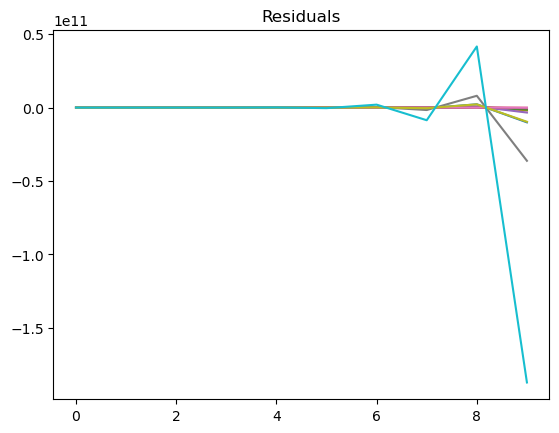

Durbin-Watson statistic for Enteric Fermentation: 1.491308557893677
Durbin-Watson statistic for Manure Management: 1.4877904826927022
Durbin-Watson statistic for Synthetic Fertilizers: 1.5550268464027965
Durbin-Watson statistic for Manure applied to Soils: 1.499252777050117
Durbin-Watson statistic for Manure left on Pasture: 1.4947442998910423
Durbin-Watson statistic for Crop Residues: 1.5056845777036656
Durbin-Watson statistic for Burning - Crop residues: 1.502773561644163
Durbin-Watson statistic for IPCC Agriculture: 1.4908754942206222
Durbin-Watson statistic for Agricultural Soils: 1.5017078177380991
Durbin-Watson statistic for Pulses, Total: 1.4922296778886228


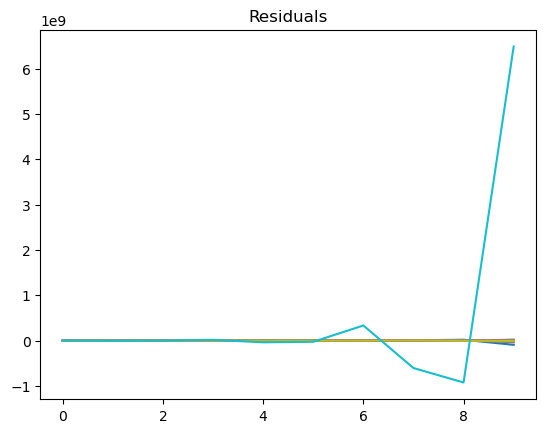

Durbin-Watson statistic for Enteric Fermentation: 1.3884555232952356
Durbin-Watson statistic for Manure Management: 1.2753585812044173
Durbin-Watson statistic for Synthetic Fertilizers: 1.6506923646584455
Durbin-Watson statistic for Manure applied to Soils: 1.416185576475138
Durbin-Watson statistic for Manure left on Pasture: 1.4445149722691968
Durbin-Watson statistic for Crop Residues: 1.5005765473302082
Durbin-Watson statistic for Burning - Crop residues: 1.809788727769937
Durbin-Watson statistic for IPCC Agriculture: 1.8320415402282073
Durbin-Watson statistic for Agricultural Soils: 0.753837359854559
Durbin-Watson statistic for Roots and Tubers, Total: 1.2907232466435021


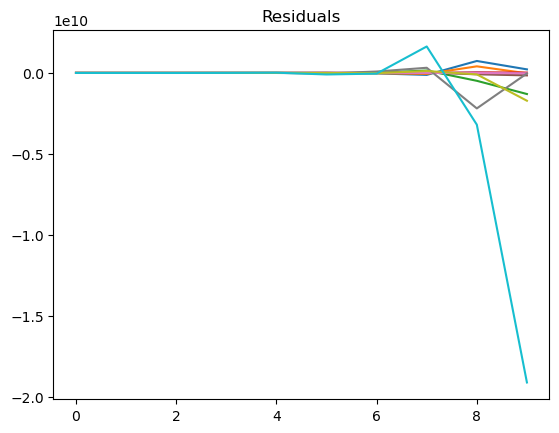

Durbin-Watson statistic for Enteric Fermentation: 1.6684595085515654
Durbin-Watson statistic for Manure Management: 2.3675117197916897
Durbin-Watson statistic for Synthetic Fertilizers: 0.5586090977812118
Durbin-Watson statistic for Manure applied to Soils: 1.163800842680992
Durbin-Watson statistic for Manure left on Pasture: 1.503631388429483
Durbin-Watson statistic for Crop Residues: 0.526813443903198
Durbin-Watson statistic for Burning - Crop residues: 0.7141087974808704
Durbin-Watson statistic for IPCC Agriculture: 2.246637879259473
Durbin-Watson statistic for Agricultural Soils: 0.9128523864920087
Durbin-Watson statistic for Rye: 0.7392186206958449


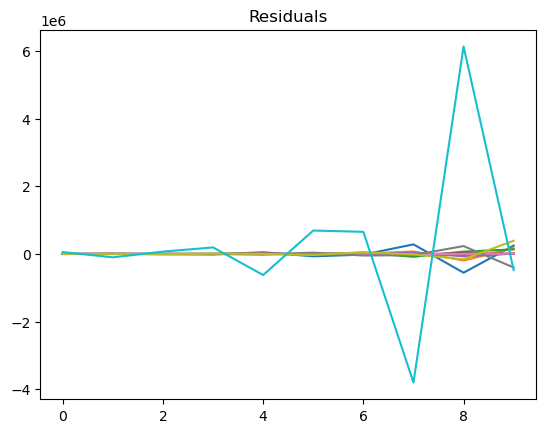

Durbin-Watson statistic for Enteric Fermentation: 3.1907764993733583
Durbin-Watson statistic for Manure Management: 2.87483045571806
Durbin-Watson statistic for Synthetic Fertilizers: 1.3809556795960887
Durbin-Watson statistic for Manure applied to Soils: 3.1825853979533467
Durbin-Watson statistic for Manure left on Pasture: 3.0999809398621245
Durbin-Watson statistic for Crop Residues: 2.8778336297986216
Durbin-Watson statistic for Burning - Crop residues: 1.1677950723676895
Durbin-Watson statistic for IPCC Agriculture: 2.2005781617396685
Durbin-Watson statistic for Agricultural Soils: 1.8324825997226437
Durbin-Watson statistic for Seed cotton: 3.069971513206906


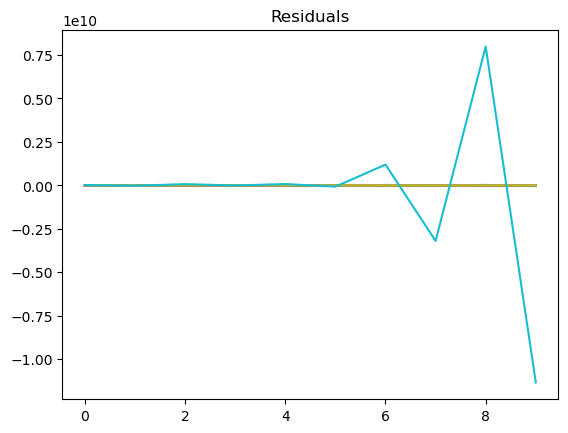

Durbin-Watson statistic for Enteric Fermentation: 2.6535655985503896
Durbin-Watson statistic for Manure Management: 2.378427902397165
Durbin-Watson statistic for Synthetic Fertilizers: 2.64498019668135
Durbin-Watson statistic for Manure applied to Soils: 2.423987548404148
Durbin-Watson statistic for Manure left on Pasture: 2.357540764166566
Durbin-Watson statistic for Crop Residues: 2.702253347296148
Durbin-Watson statistic for Burning - Crop residues: 2.8833342200443726
Durbin-Watson statistic for IPCC Agriculture: 2.3763421305673837
Durbin-Watson statistic for Agricultural Soils: 3.3228911886978443
Durbin-Watson statistic for Sheep: 2.54629537374014


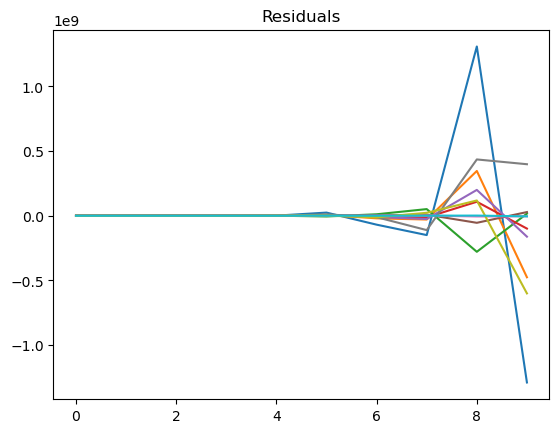

Durbin-Watson statistic for Enteric Fermentation: 2.613115380841298
Durbin-Watson statistic for Manure Management: 2.3519257577809753
Durbin-Watson statistic for Synthetic Fertilizers: 2.4482363088881187
Durbin-Watson statistic for Manure applied to Soils: 2.653876130571631
Durbin-Watson statistic for Manure left on Pasture: 2.7203953270369223
Durbin-Watson statistic for Crop Residues: 2.8150821974739046
Durbin-Watson statistic for Burning - Crop residues: 1.0281493914007969
Durbin-Watson statistic for IPCC Agriculture: 0.861361739429635
Durbin-Watson statistic for Agricultural Soils: 1.403484704682438
Durbin-Watson statistic for Sheep and Goat Meat: 1.424571690791295


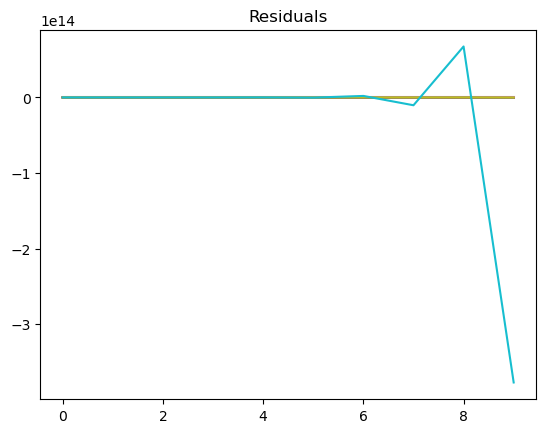

Durbin-Watson statistic for Enteric Fermentation: 1.3855741835041575
Durbin-Watson statistic for Manure Management: 1.3826662264426646
Durbin-Watson statistic for Synthetic Fertilizers: 1.3691474998687474
Durbin-Watson statistic for Manure applied to Soils: 1.386866649959459
Durbin-Watson statistic for Manure left on Pasture: 1.387476333746384
Durbin-Watson statistic for Crop Residues: 1.3826956646595572
Durbin-Watson statistic for Burning - Crop residues: 1.4728683712628459
Durbin-Watson statistic for IPCC Agriculture: 1.3904187203508547
Durbin-Watson statistic for Agricultural Soils: 1.3857094865233732
Durbin-Watson statistic for Sheep and Goats: 1.3876372976593194


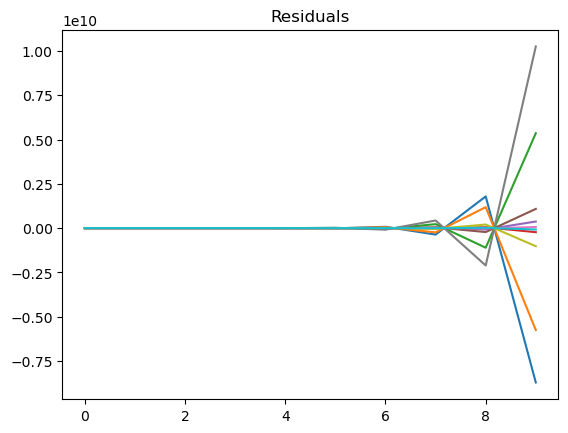

Durbin-Watson statistic for Enteric Fermentation: 1.452622471163879
Durbin-Watson statistic for Manure Management: 1.4532714242669162
Durbin-Watson statistic for Synthetic Fertilizers: 1.4554810200284551
Durbin-Watson statistic for Manure applied to Soils: 1.4507514580284842
Durbin-Watson statistic for Manure left on Pasture: 1.46217465357551
Durbin-Watson statistic for Crop Residues: 1.4547498674520274
Durbin-Watson statistic for Burning - Crop residues: 1.4572901994269487
Durbin-Watson statistic for IPCC Agriculture: 1.453537323882956
Durbin-Watson statistic for Agricultural Soils: 1.4366787482074928
Durbin-Watson statistic for Skins, goat, fresh: 1.4553124006499052


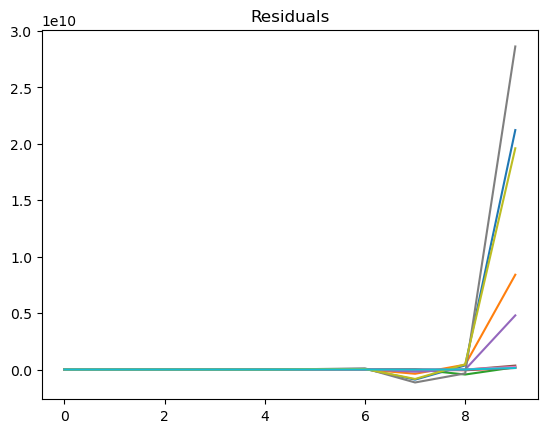

Durbin-Watson statistic for Enteric Fermentation: 0.9694806846340257
Durbin-Watson statistic for Manure Management: 0.9075235611966299
Durbin-Watson statistic for Synthetic Fertilizers: 2.667343476684271
Durbin-Watson statistic for Manure applied to Soils: 1.9286010957753033
Durbin-Watson statistic for Manure left on Pasture: 1.0023588614307959
Durbin-Watson statistic for Crop Residues: 1.1338379288139666
Durbin-Watson statistic for Burning - Crop residues: 0.9356635525563282
Durbin-Watson statistic for IPCC Agriculture: 1.0250974702193474
Durbin-Watson statistic for Agricultural Soils: 0.9576734571495169
Durbin-Watson statistic for Skins, sheep, fresh: 0.972898729862585


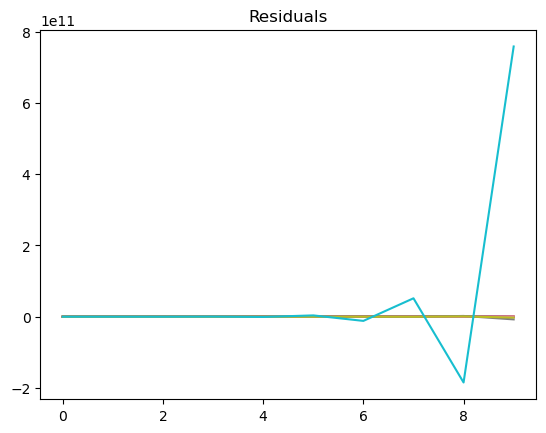

Durbin-Watson statistic for Enteric Fermentation: 1.6358506844222949
Durbin-Watson statistic for Manure Management: 1.4708913869620637
Durbin-Watson statistic for Synthetic Fertilizers: 1.6777281521633587
Durbin-Watson statistic for Manure applied to Soils: 1.5574317856214424
Durbin-Watson statistic for Manure left on Pasture: 1.6232277912636068
Durbin-Watson statistic for Crop Residues: 1.6331007387982945
Durbin-Watson statistic for Burning - Crop residues: 1.629937191301256
Durbin-Watson statistic for IPCC Agriculture: 1.6127331897796482
Durbin-Watson statistic for Agricultural Soils: 1.641834193558065
Durbin-Watson statistic for Sugar Crops Primary: 1.5511419922556784


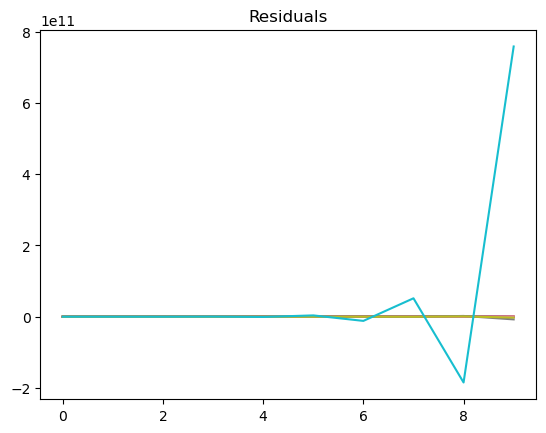

Durbin-Watson statistic for Enteric Fermentation: 1.6358506844222949
Durbin-Watson statistic for Manure Management: 1.4708913869620637
Durbin-Watson statistic for Synthetic Fertilizers: 1.6777281521633587
Durbin-Watson statistic for Manure applied to Soils: 1.5574317856214424
Durbin-Watson statistic for Manure left on Pasture: 1.6232277912636068
Durbin-Watson statistic for Crop Residues: 1.6331007387982945
Durbin-Watson statistic for Burning - Crop residues: 1.629937191301256
Durbin-Watson statistic for IPCC Agriculture: 1.6127331897796482
Durbin-Watson statistic for Agricultural Soils: 1.641834193558065
Durbin-Watson statistic for Sugar beet: 1.5511419922556784


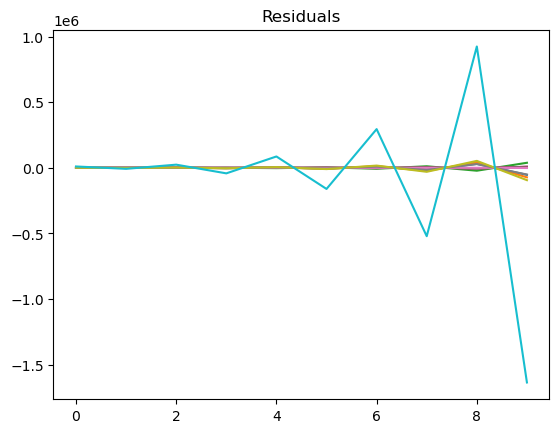

Durbin-Watson statistic for Enteric Fermentation: 2.4487642240667924
Durbin-Watson statistic for Manure Management: 2.452042330133995
Durbin-Watson statistic for Synthetic Fertilizers: 2.4438592951011904
Durbin-Watson statistic for Manure applied to Soils: 2.4523172547364336
Durbin-Watson statistic for Manure left on Pasture: 2.459992319046638
Durbin-Watson statistic for Crop Residues: 2.453118915099286
Durbin-Watson statistic for Burning - Crop residues: 2.454389030816759
Durbin-Watson statistic for IPCC Agriculture: 2.451669857149058
Durbin-Watson statistic for Agricultural Soils: 2.454193083150099
Durbin-Watson statistic for Sunflower seed: 2.446862514213395


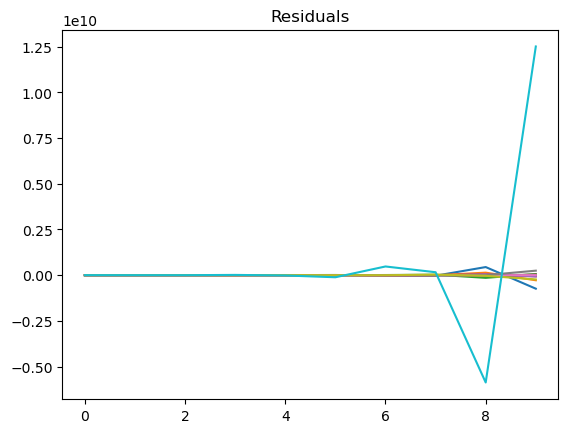

Durbin-Watson statistic for Enteric Fermentation: 2.178792053943764
Durbin-Watson statistic for Manure Management: 1.9981829687727082
Durbin-Watson statistic for Synthetic Fertilizers: 2.825739555698069
Durbin-Watson statistic for Manure applied to Soils: 2.229071849170946
Durbin-Watson statistic for Manure left on Pasture: 2.231104297362803
Durbin-Watson statistic for Crop Residues: 2.542954243624177
Durbin-Watson statistic for Burning - Crop residues: 2.792965284993886
Durbin-Watson statistic for IPCC Agriculture: 1.01762506465009
Durbin-Watson statistic for Agricultural Soils: 0.7843600084917091
Durbin-Watson statistic for Tobacco, unmanufactured: 1.9593090832666207


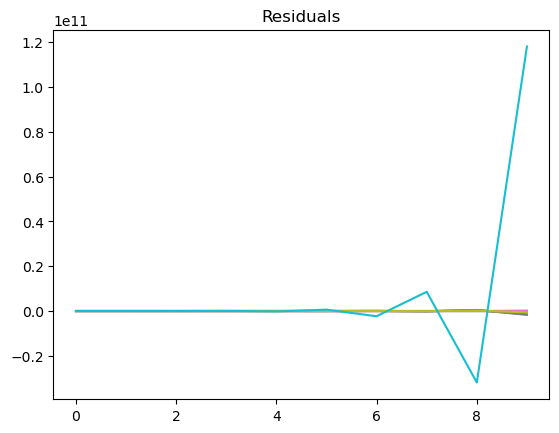

Durbin-Watson statistic for Enteric Fermentation: 1.6129847452656438
Durbin-Watson statistic for Manure Management: 1.6128055066309448
Durbin-Watson statistic for Synthetic Fertilizers: 1.6122771247658267
Durbin-Watson statistic for Manure applied to Soils: 1.6131040564370733
Durbin-Watson statistic for Manure left on Pasture: 1.613089448198775
Durbin-Watson statistic for Crop Residues: 1.6129827824264449
Durbin-Watson statistic for Burning - Crop residues: 1.6209745796315316
Durbin-Watson statistic for IPCC Agriculture: 1.613208619997985
Durbin-Watson statistic for Agricultural Soils: 1.6128516856567414
Durbin-Watson statistic for Tomatoes: 1.6129907500985103


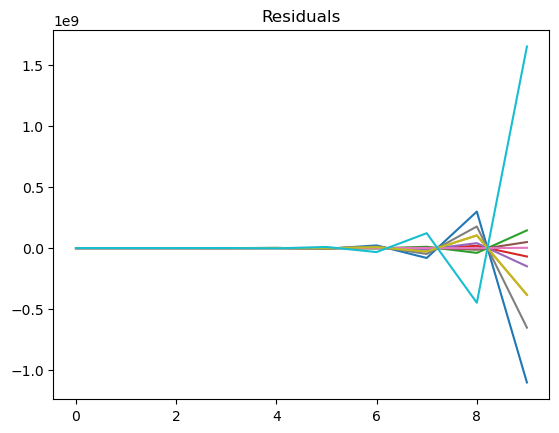

Durbin-Watson statistic for Enteric Fermentation: 1.6166901340721918
Durbin-Watson statistic for Manure Management: 1.61666399456076
Durbin-Watson statistic for Synthetic Fertilizers: 1.6167366222023196
Durbin-Watson statistic for Manure applied to Soils: 1.6167036893536315
Durbin-Watson statistic for Manure left on Pasture: 1.6166987967237005
Durbin-Watson statistic for Crop Residues: 1.6167227230806112
Durbin-Watson statistic for Burning - Crop residues: 1.617042871637913
Durbin-Watson statistic for IPCC Agriculture: 1.6168140233804495
Durbin-Watson statistic for Agricultural Soils: 1.6166192458635722
Durbin-Watson statistic for Vegetables Primary: 1.6157495016370544


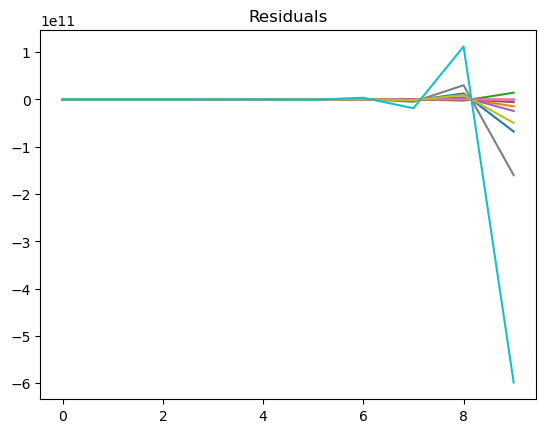

Durbin-Watson statistic for Enteric Fermentation: 1.4081458266350197
Durbin-Watson statistic for Manure Management: 1.3991495812908716
Durbin-Watson statistic for Synthetic Fertilizers: 1.3594212180084262
Durbin-Watson statistic for Manure applied to Soils: 1.4798406497749836
Durbin-Watson statistic for Manure left on Pasture: 1.4134926697770998
Durbin-Watson statistic for Crop Residues: 1.4211247957693955
Durbin-Watson statistic for Burning - Crop residues: 1.4174933497974882
Durbin-Watson statistic for IPCC Agriculture: 1.4100142638637487
Durbin-Watson statistic for Agricultural Soils: 1.4215779920828486
Durbin-Watson statistic for Vetches: 1.4079785609100617


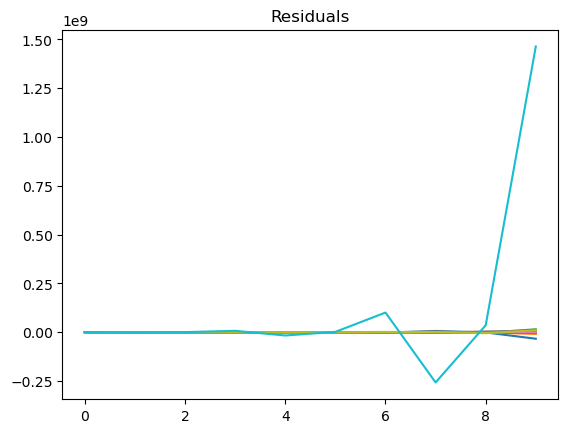

Durbin-Watson statistic for Enteric Fermentation: 0.9932898465719371
Durbin-Watson statistic for Manure Management: 0.8936789684041264
Durbin-Watson statistic for Synthetic Fertilizers: 1.448374125590049
Durbin-Watson statistic for Manure applied to Soils: 1.0069650145302613
Durbin-Watson statistic for Manure left on Pasture: 1.0196896766940315
Durbin-Watson statistic for Crop Residues: 1.1695535845498133
Durbin-Watson statistic for Burning - Crop residues: 1.394976927080322
Durbin-Watson statistic for IPCC Agriculture: 0.8543126273376963
Durbin-Watson statistic for Agricultural Soils: 2.131414461349288
Durbin-Watson statistic for Wheat: 1.0201235641801731


TypeError: cannot unpack non-iterable NoneType object

In [14]:
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

display(pre_process_df.head(5))
df_item, df_emi, emission_list = pre_processing()
mae,mse,sqr = forecasting1(df_item, df_emi, emission_list)

In [15]:
# Evaluation metrics
#mae,mse,sqr = forecasting(df_item, df_emi, emission_list)
average_mean_absolute_error = (sum(mae)/len(mae))
average_mean_squared_error = (sum(mse)/len(mse))
average_sqrt = (sum(sqr)/len(sqr))
print('Mean absolute error:', average_mean_absolute_error)
print('Mean squared error:', average_mean_squared_error)
print('Root mean squared error:', average_sqrt)

Mean absolute error: 0.43433170378859126
Mean squared error: 0.26571562106625063
Root mean squared error: 0.5042058461072553
